In [78]:
import os
import shutil
import pickle
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from datetime import date
from datetime import datetime
#from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf, month_plot # => noch pacf nutzen???
from statsmodels.tsa.seasonal import STL
from autots import AutoTS
from autots.evaluator.auto_model import remove_leading_zeros


# Data exploration

In [2]:
data = pd.read_csv("../data/traffic.csv", parse_dates=True, index_col="DateTime")
data.drop(["ID"], axis=1, inplace=True)
datetime_data = data.copy()
grouped_datetime_data = datetime_data.groupby(by="Junction")

In [3]:
junction_to_color_mapping = {
    1: "blue",
    2: "green",
    3: "red",
    4: "yellow",
}

In [4]:
def create_observation_count_per_junction_barplot(data_grouped_by_junction):
    fig, ax = plt.subplots(figsize=(8,5))
    
    x_values = []
    y_values = []
    color_list = []
    
    for key, group in data_grouped_by_junction:
        x_values.append(key)
        y_values.append(group.size)
        color_list.append(junction_to_color_mapping[key])
        
    ax.bar(x_values, y_values, color=color_list)
    ax.set_xticks(x_values)
    ax.set_xticklabels(
        map(lambda x: "junction_{0}".format(x), x_values)
    )
    ax.set_title("Number of datapoints available in the traffic dataset per junction", fontsize=15)
    ax.set_xlabel("Junctions present in the traffic dataset")
    ax.set_ylabel("Number of available datapoints")
    
    plt.savefig("./eda_plots/traffic_dataset_datapoint_per_junction_bar_plot.png")

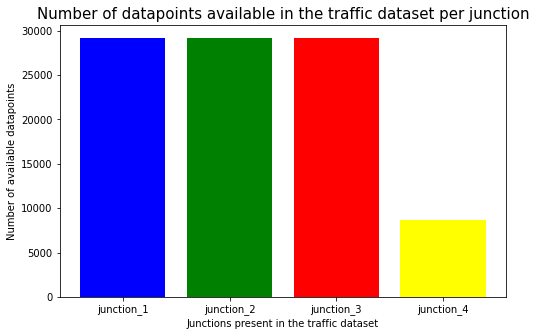

In [5]:
create_observation_count_per_junction_barplot(grouped_datetime_data)

In [6]:
def create_bar_plot_by_junction(data_grouped_by_junction):
    fig, axs = plt.subplots(4, 1, figsize=(20,25))
   
    
    for key, group in data_grouped_by_junction:
        vehicle_counts = group["Vehicles"].value_counts().sort_index()
        vehicle_counts.plot(
            kind="bar", 
            ax=axs[key - 1], 
            color=junction_to_color_mapping[key],
        )
        
        fig.suptitle(
            "Distinct vehicle count value occurences per junction of the traffic dataset",
            fontsize=20,
        )
        
        axs[key - 1].set_title(
            "Vehicle count value occurences at junction {0}".format(key), 
            fontsize=18,
        )
        axs[key - 1].set_xlabel(
            "Distinct vehicle count values", 
            fontsize=14,
        )
        axs[key - 1].set_ylabel(
            "Occurence of the distinct vehicle count values", 
            fontsize=14,
        )
        
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
        
    plt.savefig("./eda_plots/traffic_dataset_vehicle_count_per_junction_bar_plot.png")

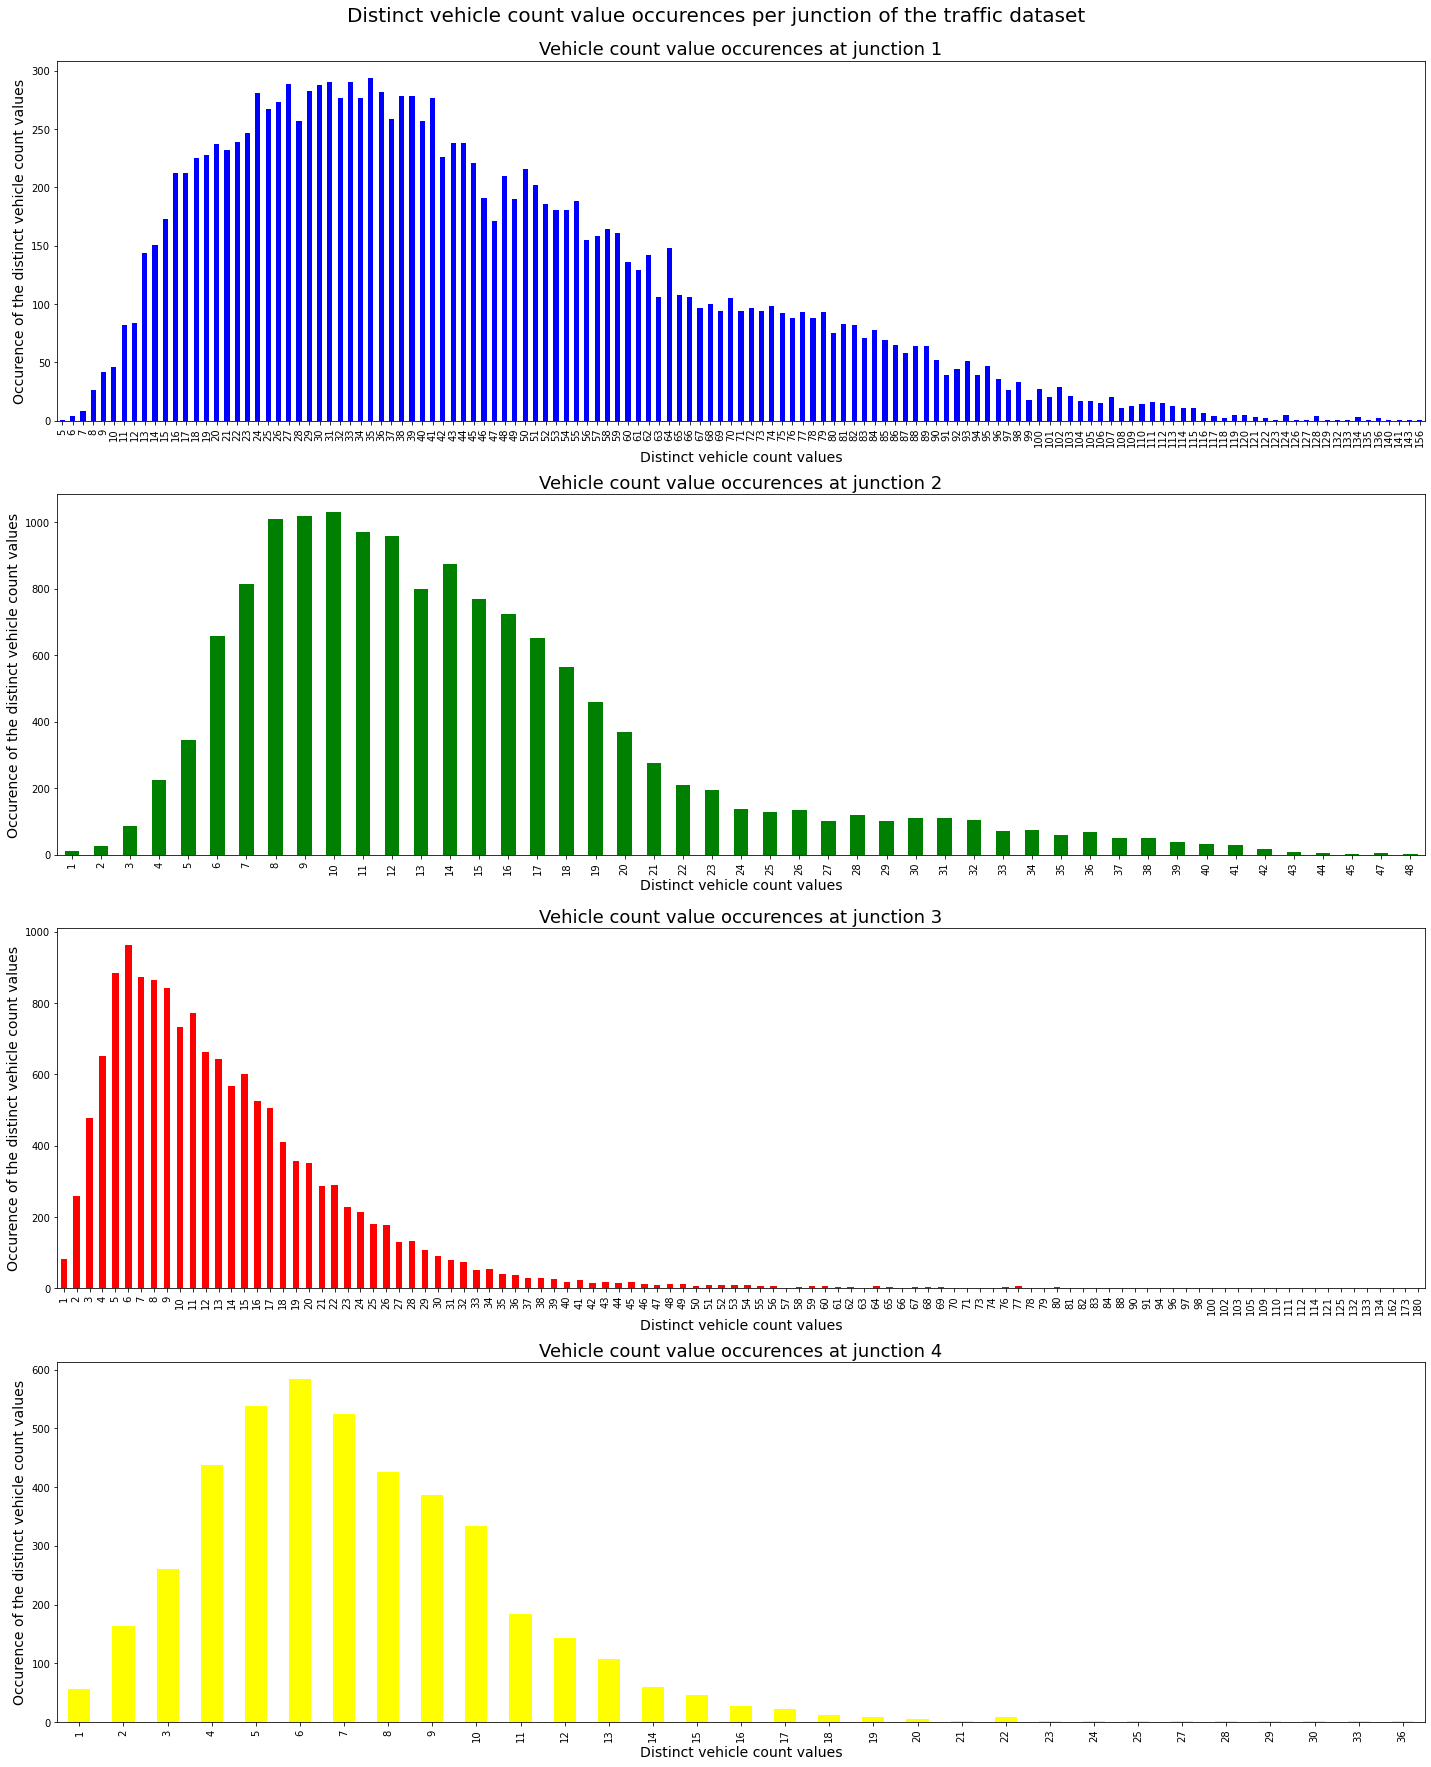

In [7]:
create_bar_plot_by_junction(grouped_datetime_data)

In [8]:
def create_hist_plot_by_junction(data_grouped_by_junction):
    fig, axs = plt.subplots(
        2, 
        2, 
        figsize=(20,20),
        sharex=True,
        sharey=True,
    )
    
    fig.suptitle(
            "Histograms of the vehicle counts of the traffic dataset"
            " per junction with identicall x and y axis scale",
            fontsize=20,
        )
    
    column = 0
    row = 0
    
    for key, group in data_grouped_by_junction:
        group.hist(
            ax=axs[column, row],
            column="Vehicles",
            bins=25,
            grid=False,
            color=junction_to_color_mapping[key],
        )
        
        axs[column, row].xaxis.set_tick_params(labelbottom=True)
        axs[column, row].yaxis.set_tick_params(labelbottom=True)
        axs[column, row].set_title(
            "Histogram for vehicle count data at junction {0}".format(key),
            fontsize=18,
        )
        axs[column, row].set_xlabel("Vehicle count values", fontsize=14,)
        axs[column, row].set_ylabel(
            "Occurence of values in specific vehicle count bin",
            fontsize=14,
        )

        
        column = 0 if key % 2 == 0 else column + 1
        row = row + 1 if column % 2 == 0 else row
        
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)

    plt.savefig("./eda_plots/traffic_dataset_vehicle_count_per_junction_hist.png")


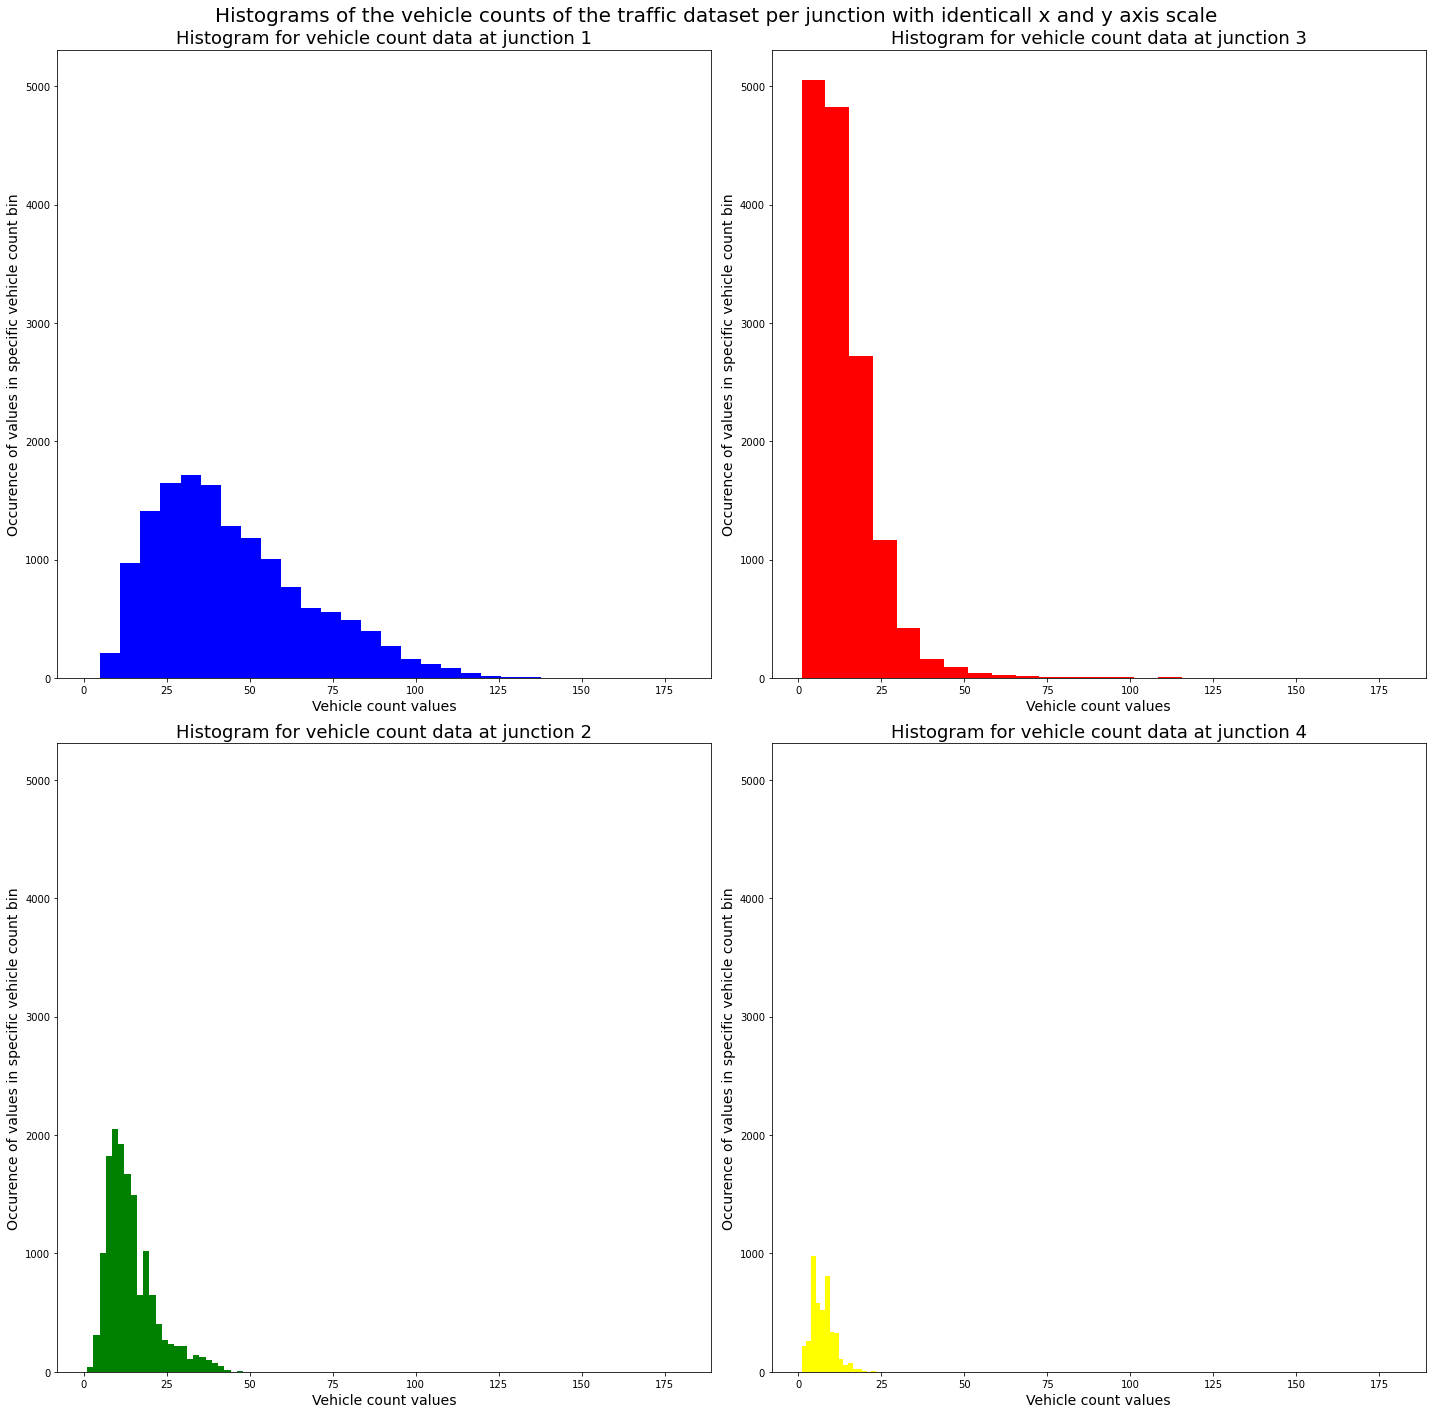

In [9]:
create_hist_plot_by_junction(grouped_datetime_data)

In [10]:
def plot_all_junction_timeseries_in_one_plot(data_grouped_by_junction, time_frequence_shown):
        fig, ax = plt.subplots(figsize=(25,12))
        
        frequency_mapping_dict = {
            "H": "Hour",
            "D": "Day",
            "W": "Week",
            "M": "Month",
            "Y": "Year",
        }
        
        for key, group in data_grouped_by_junction:
            group.drop(["Junction"], axis=1, inplace=True)
            resampled_data = group.resample(time_frequence_shown).mean()
            
            ax.plot(
                resampled_data, 
                color = junction_to_color_mapping[key],
                label = "junction_{0}".format(key)
            )
                    
        leg = ax.legend(fontsize="xx-large")

        for line in leg.get_lines():
            line.set_linewidth(6)
        
        if time_frequence_shown == "H":
            ax.set_title(
                ("{0}ly vehicle count per junction"        
                " in the traffic dataset").format(frequency_mapping_dict["H"]),
                fontsize = 25,
            )
        else:
            ax.set_title(
                ("{0}ly vehicle count per junction"        
                 " in the traffic dataset calculated as mean of the hourly dates").format(
                    frequency_mapping_dict[time_frequence_shown]
                ),
                fontsize = 25,
            )
        
        ax.set_xlabel("Timestamp t of data collection", fontsize=18)
        ax.set_ylabel("Vehicle count at time t", fontsize=18)
        
        plt.savefig(
            (
                "./eda_plots/traffic_dataset_combined"
                "_timeseries_plot_{0}_frequency.png"
            ).format(frequency_mapping_dict[time_frequence_shown])
        )

        
        # ggf abstand title plot vergrößern, ticks größerre font?

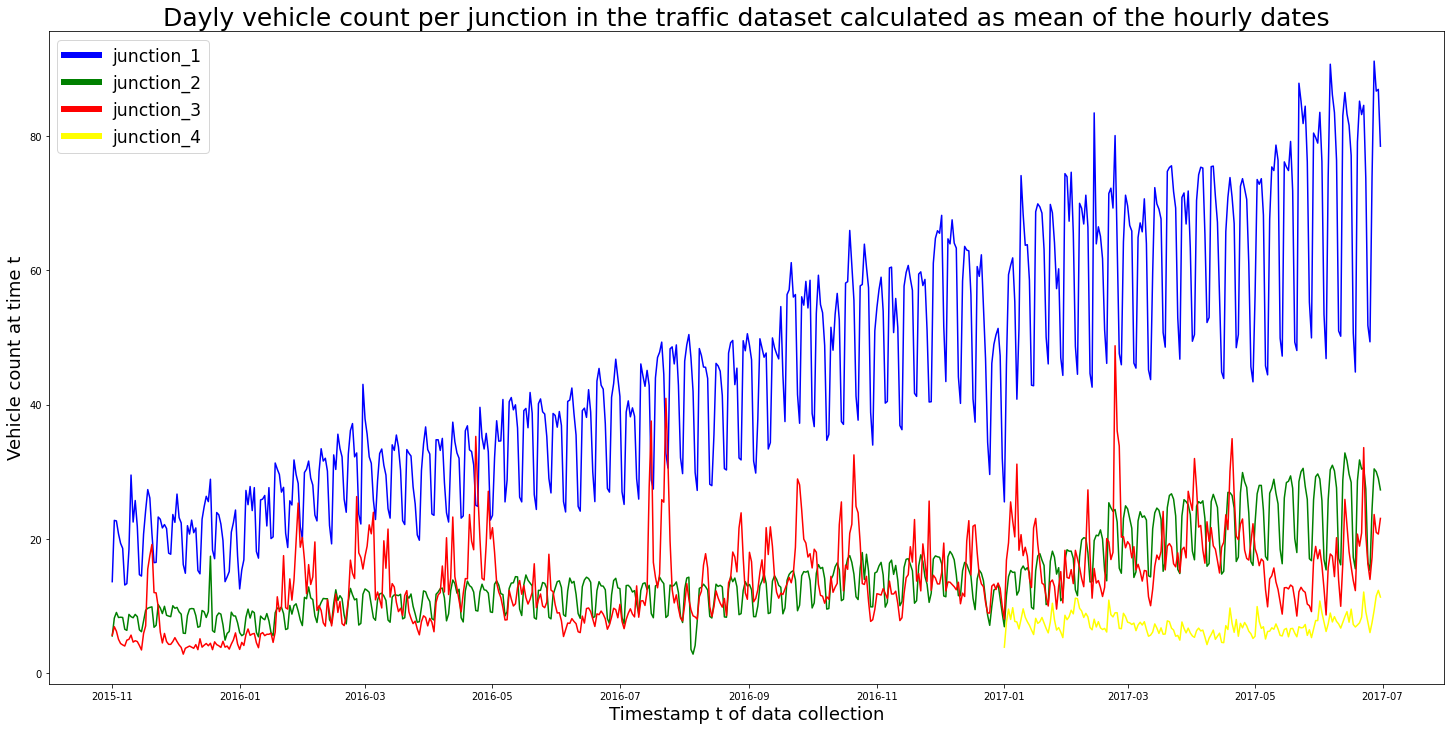

In [11]:
plot_all_junction_timeseries_in_one_plot(grouped_datetime_data, "D")

In [12]:
def plot_all_junction_timeseries_decomposition_in_one_plot(data_grouped_by_junction, time_frequence_shown):
    fig, axs = plt.subplots(
        nrows = 4, 
        ncols = 1, 
        figsize=(25,30),
    )
    
    frequency_mapping_dict = {
        "H": "Hour",
        "D": "Day",
        "W": "Week",
        "M": "Month",
        "Y": "Year",
    }
    
    for key, group in data_grouped_by_junction:
        group.drop(["Junction"], axis=1, inplace=True)
        resampled_data = group.resample(time_frequence_shown).mean()
        decomposed_ts = STL(resampled_data).fit()
        
        axs[0].plot(
            decomposed_ts.observed,
            color = junction_to_color_mapping[key],
            label = "junction_{0}".format(key),
        )
        axs[1].plot(
            decomposed_ts.trend,
            color = junction_to_color_mapping[key],
            #label = "junction_{0}".format(key),
        )
        axs[2].plot(
            decomposed_ts.seasonal,
            color = junction_to_color_mapping[key],
            #label = "junction_{0}".format(key),
        )
        axs[3].plot(
            decomposed_ts.resid,
            color = junction_to_color_mapping[key],
            #label = "junction_{0}".format(key),
        )
        
        
    if time_frequence_shown == "H":
            fig.suptitle(
                ("Decomposition of the {0}ly vehicle count data per junction"        
                " in the traffic dataset").format(frequency_mapping_dict["H"]),
                fontsize = 22,
            )
    else:
        fig.suptitle(
            ("Decomposition of the {0}ly vehicle count data per junction"        
             " in the traffic dataset calculated as mean of the hourly dates").format(
                frequency_mapping_dict[time_frequence_shown]
            ),
            fontsize = 22,
        )
    
    axs[0].set_title("Observed time series data by junction", fontsize=20)
    axs[1].set_title("Trend component of time series data by junction", fontsize=20)
    axs[2].set_title("Seasonal component of time series data by junction", fontsize=20)
    axs[3].set_title("Residuals of time series data by junction", fontsize=20)
    
    axs[0].set_xlabel("Timestamp t of data collection", fontsize=16)
    axs[0].set_ylabel("Vehicle count at time t", fontsize=16)
    axs[1].set_xlabel("Timestamp t of data collection", fontsize=16)
    axs[1].set_ylabel("Vehicle count at time t", fontsize=16)
    axs[2].set_xlabel("Timestamp t of data collection", fontsize=16)
    axs[2].set_ylabel("Vehicle count at time t", fontsize=16)
    axs[3].set_xlabel("Timestamp t of data collection", fontsize=16)
    axs[3].set_ylabel("Vehicle count at time t", fontsize=16)
        
    leg = fig.legend(
        fontsize="xx-large", 
        #loc = "lower center",
        ncol = 2,
        bbox_to_anchor =(0.6, 0.095)
    )
    
    for line in leg.get_lines():
            line.set_linewidth(6)
            
    # y-achsen beschriftung anpassen!!!!!!!!!!!!!!!!!!!!!!!!!!!

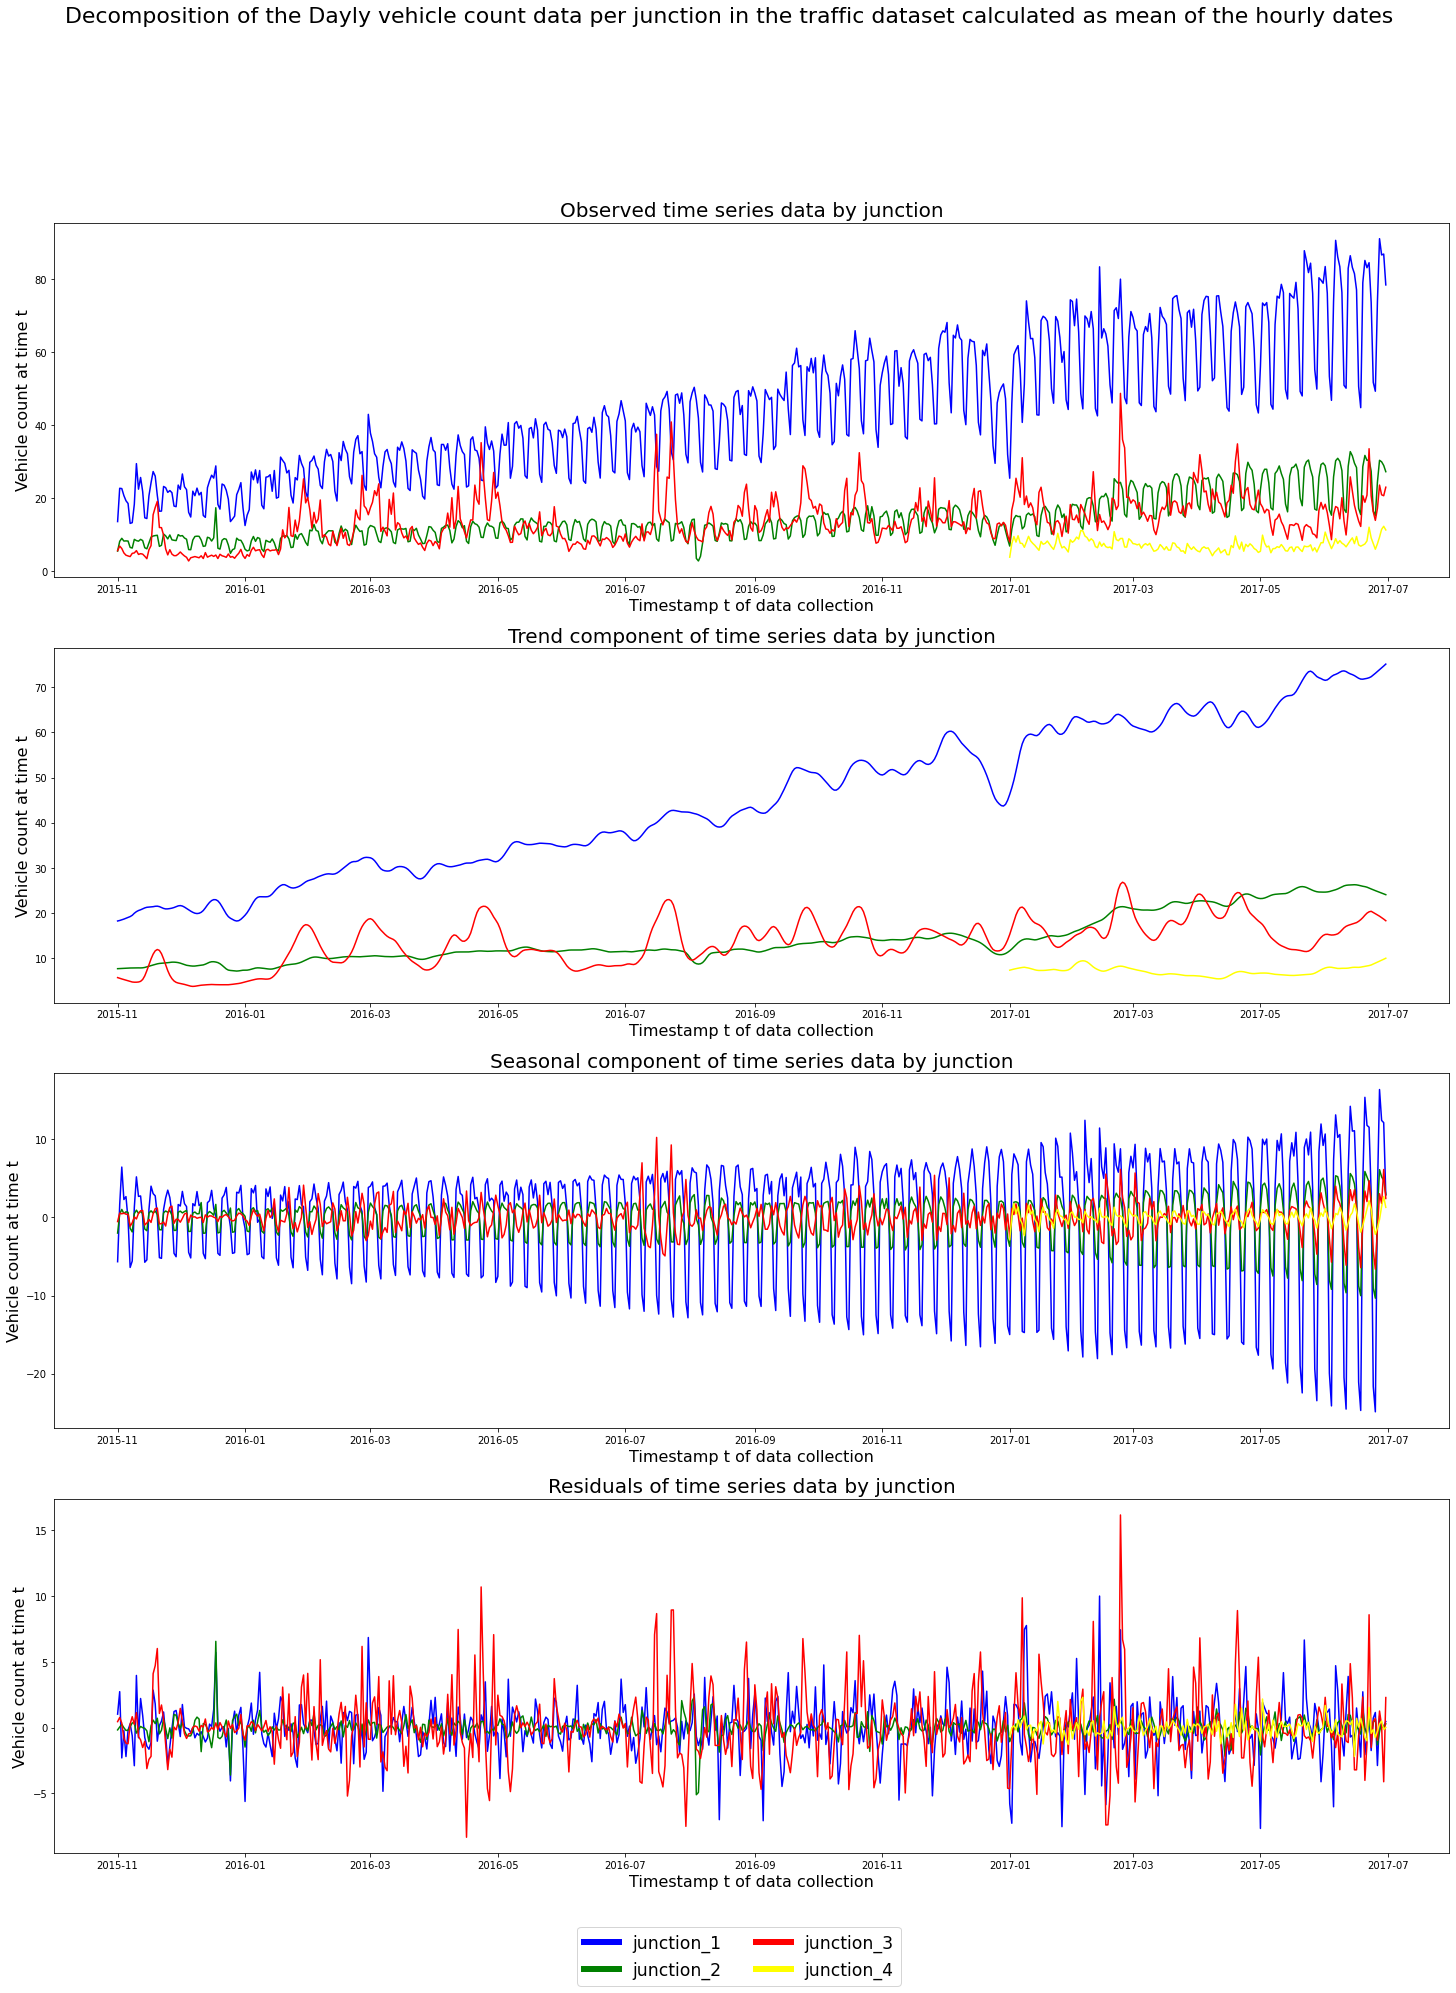

In [13]:
plot_all_junction_timeseries_decomposition_in_one_plot(grouped_datetime_data, "D")

In [14]:
def plot_autocorrelation_by_junctions(data_grouped_by_junction):
    fig, axs = plt.subplots(
        2, 
        2, 
        figsize=(20,25),
    )
    
    #fig.suptitle(
     #       "Histograms of the vehicle counts of the traffic dataset"
     #       " per junction with identicall x and y axis scale",
      #      fontsize=20,
     #   )
    
    column = 0
    row = 0
    
    for key, group in data_grouped_by_junction:
        #axs[column, row].set_title(
        #    "Histogram for vehicle count data at junction {0}".format(key),
        #    fontsize=18,
        #)
        #axs[column, row].set_xlabel("Vehicle count values", fontsize=14,)
        #axs[column, row].set_ylabel(
        #    "Occurence of specific vehicle count bin",
        #    fontsize=14,
        #)
        
        plot_acf(
            group["Vehicles"], 
            ax=axs[column, row],
            #title
            auto_ylims=True,
            vlines_kwargs = {"colors": junction_to_color_mapping[key]},
            color=junction_to_color_mapping[key],
        )

        
        column = 0 if key % 2 == 0 else column + 1
        row = row + 1 if column % 2 == 0 else row
        
    fig.tight_layout()
    fig.subplots_adjust(top=0.95)
    
    #plt.savefig("./eda_plots/traffic_dataset_vehicle_bar_plot.png")

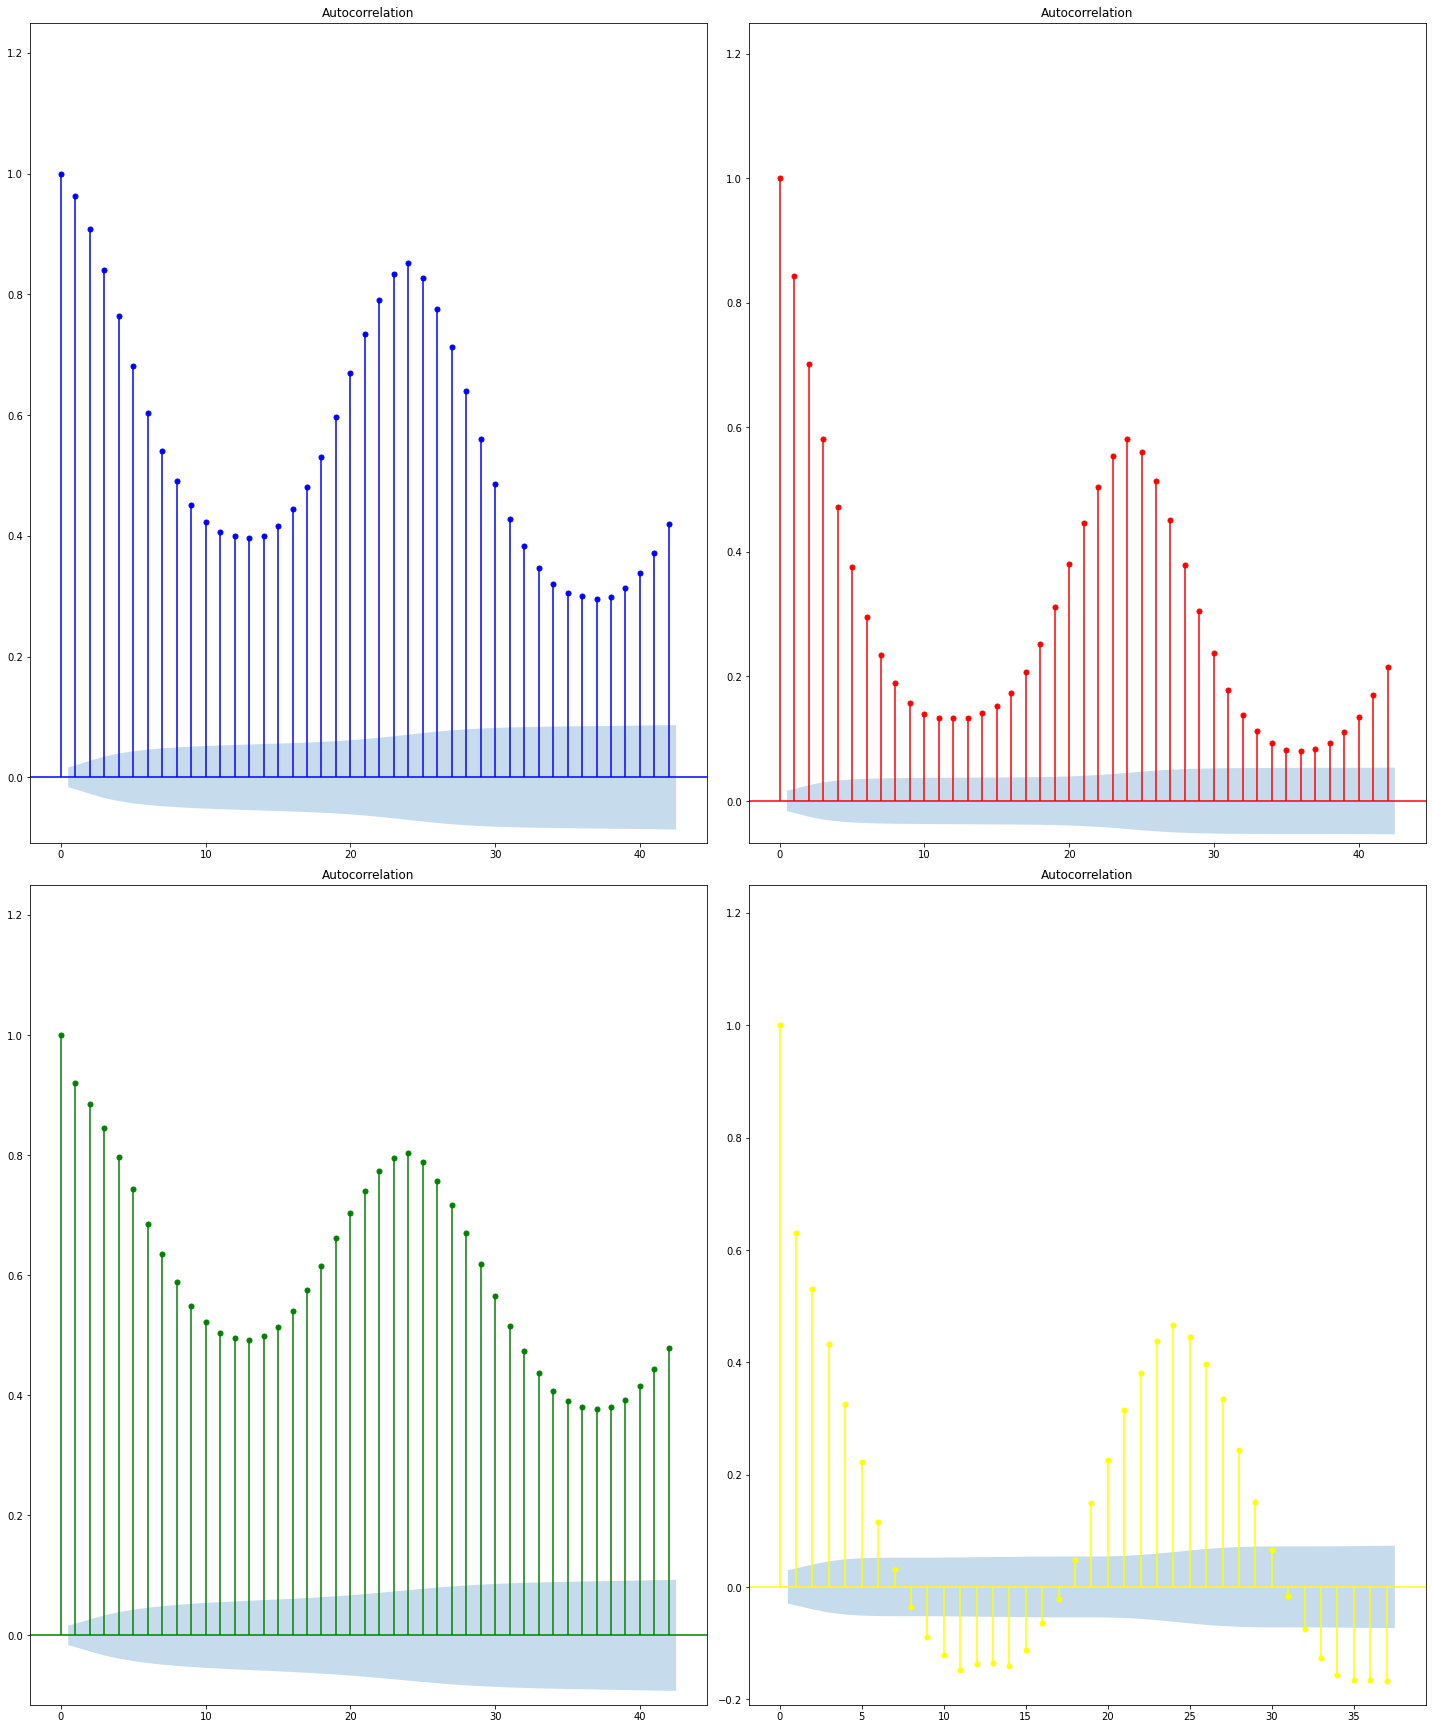

In [15]:
plot_autocorrelation_by_junctions(grouped_datetime_data)

In [16]:
# => stat test ob statisch? => hätte das implikationen oder kann das durch preprocessing egal gemacht werden????

# Training

In [17]:
# metric_weighting: dict = {
#            'smape_weighting': 5,
#            'mae_weighting': 2,
#            'rmse_weighting': 2,
#            'made_weighting': 0.5,
#            'mage_weighting': 0,
#            'mle_weighting': 0,
#            'imle_weighting': 0,
#            'spl_weighting': 3,
#            'containment_weighting': 0,
#            'contour_weighting': 1,
#            'runtime_weighting': 0.05,
#            'oda_weighting': 0.001,
#        },

In [18]:
def train_models_per_junction(data_grouped_by_junction, autots_param_dict):
    result_model_junction_key_list = []
    
    for key, group in data_grouped_by_junction:
        group.drop(["Junction"], axis=1, inplace=True)
        group["Vehicles"] = group["Vehicles"].astype(float)

        autots_model = AutoTS(**autots_param_dict)
        
        junction_resulting_model = autots_model.fit(group)
        
        result_model_junction_key_list.append((junction_resulting_model, key))
        
    return result_model_junction_key_list    

In [60]:
#model_list="all",  
#transformer_list="all",
#drop_most_recent=1,
# explizit freq und models angeben (transformers nicht!?!)
  

autots_param_dict = {
    "forecast_length": 5,
    "frequency": "H",
    "prediction_interval": 0.9,
    "ensemble": None,
    "model_list": "superfast",
    "transformer_list": "superfast",
    "max_generations": 25,
    "num_validations": 5,
    "validation_method": "backwards",
    "n_jobs": 2,
    "no_negatives": True,
    "holiday_country": "US",
}


resulting_models = train_models_per_junction(grouped_datetime_data, autots_param_dict)

Model Number: 1 with model AverageValueNaive in generation 0 of 25
Model Number: 2 with model AverageValueNaive in generation 0 of 25
Model Number: 3 with model AverageValueNaive in generation 0 of 25
Model Number: 4 with model GLS in generation 0 of 25
Model Number: 5 with model GLS in generation 0 of 25
Model Number: 6 with model LastValueNaive in generation 0 of 25
Model Number: 7 with model LastValueNaive in generation 0 of 25
Model Number: 8 with model LastValueNaive in generation 0 of 25
Model Number: 9 with model LastValueNaive in generation 0 of 25
Model Number: 10 with model SeasonalNaive in generation 0 of 25
Model Number: 11 with model SeasonalNaive in generation 0 of 25
Model Number: 12 with model SeasonalNaive in generation 0 of 25
Model Number: 13 with model ConstantNaive in generation 0 of 25
Model Number: 14 with model SeasonalNaive in generation 0 of 25
Model Number: 15 with model SeasonalNaive in generation 0 of 25
Model Number: 16 with model ConstantNaive in generati

Model Number: 251 with model SeasonalNaive in generation 10 of 25
Model Number: 252 with model SeasonalNaive in generation 10 of 25
Model Number: 253 with model SeasonalNaive in generation 10 of 25
Model Number: 254 with model SeasonalNaive in generation 10 of 25
Model Number: 255 with model LastValueNaive in generation 10 of 25
New Generation: 11 of 25
Model Number: 256 with model AverageValueNaive in generation 11 of 25
Model Number: 257 with model SeasonalNaive in generation 11 of 25
Model Number: 258 with model SeasonalNaive in generation 11 of 25
Model Number: 259 with model SeasonalNaive in generation 11 of 25
Model Number: 260 with model LastValueNaive in generation 11 of 25
Model Number: 261 with model AverageValueNaive in generation 11 of 25
Model Number: 262 with model SeasonalNaive in generation 11 of 25
Model Number: 263 with model AverageValueNaive in generation 11 of 25
Model Number: 264 with model SeasonalNaive in generation 11 of 25
Model Number: 265 with model Seasonal

Model Number: 370 with model LastValueNaive in generation 18 of 25
Model Number: 371 with model AverageValueNaive in generation 18 of 25
Model Number: 372 with model SeasonalNaive in generation 18 of 25
Model Number: 373 with model SeasonalNaive in generation 18 of 25
Model Number: 374 with model AverageValueNaive in generation 18 of 25
Model Number: 375 with model LastValueNaive in generation 18 of 25
New Generation: 19 of 25
Model Number: 376 with model AverageValueNaive in generation 19 of 25
Model Number: 377 with model SeasonalNaive in generation 19 of 25
Model Number: 378 with model AverageValueNaive in generation 19 of 25
Model Number: 379 with model LastValueNaive in generation 19 of 25
Model Number: 380 with model LastValueNaive in generation 19 of 25
Model Number: 381 with model AverageValueNaive in generation 19 of 25
Model Number: 382 with model SeasonalNaive in generation 19 of 25
Model Number: 383 with model SeasonalNaive in generation 19 of 25
Model Number: 384 with mode

24 - AverageValueNaive with avg smape 14.24: 
Model Number: 25 of 68 with model AverageValueNaive for Validation 1
📈 25 - AverageValueNaive with avg smape 3.91: 
Model Number: 26 of 68 with model AverageValueNaive for Validation 1
26 - AverageValueNaive with avg smape 10.17: 
Model Number: 27 of 68 with model AverageValueNaive for Validation 1
27 - AverageValueNaive with avg smape 10.15: 
Model Number: 28 of 68 with model AverageValueNaive for Validation 1
28 - AverageValueNaive with avg smape 10.15: 
Model Number: 29 of 68 with model AverageValueNaive for Validation 1
29 - AverageValueNaive with avg smape 4.59: 
Model Number: 30 of 68 with model AverageValueNaive for Validation 1
30 - AverageValueNaive with avg smape 4.6: 
Model Number: 31 of 68 with model LastValueNaive for Validation 1
31 - LastValueNaive with avg smape 40.39: 
Model Number: 32 of 68 with model LastValueNaive for Validation 1
32 - LastValueNaive with avg smape 40.5: 
Model Number: 33 of 68 with model LastValueNaive 

Model Number: 34 of 68 with model LastValueNaive for Validation 2
34 - LastValueNaive with avg smape 50.04: 
Model Number: 35 of 68 with model LastValueNaive for Validation 2
35 - LastValueNaive with avg smape 50.04: 
Model Number: 36 of 68 with model LastValueNaive for Validation 2
36 - LastValueNaive with avg smape 49.83: 
Model Number: 37 of 68 with model LastValueNaive for Validation 2
37 - LastValueNaive with avg smape 49.74: 
Model Number: 38 of 68 with model LastValueNaive for Validation 2
38 - LastValueNaive with avg smape 49.74: 
Model Number: 39 of 68 with model LastValueNaive for Validation 2
39 - LastValueNaive with avg smape 49.8: 
Model Number: 40 of 68 with model LastValueNaive for Validation 2
40 - LastValueNaive with avg smape 49.8: 
Model Number: 41 of 68 with model LastValueNaive for Validation 2
41 - LastValueNaive with avg smape 49.8: 
Model Number: 42 of 68 with model LastValueNaive for Validation 2
42 - LastValueNaive with avg smape 49.79: 
Model Number: 43 of 68

43 - ConstantNaive with avg smape 20.37: 
Model Number: 44 of 68 with model LastValueNaive for Validation 3
44 - LastValueNaive with avg smape 23.66: 
Model Number: 45 of 68 with model LastValueNaive for Validation 3
45 - LastValueNaive with avg smape 23.66: 
Model Number: 46 of 68 with model LastValueNaive for Validation 3
46 - LastValueNaive with avg smape 23.66: 
Model Number: 47 of 68 with model ConstantNaive for Validation 3
📈 47 - ConstantNaive with avg smape 12.9: 
Model Number: 48 of 68 with model GLS for Validation 3
48 - GLS with avg smape 15.31: 
Model Number: 49 of 68 with model GLS for Validation 3
49 - GLS with avg smape 12.9: 
Model Number: 50 of 68 with model GLS for Validation 3
50 - GLS with avg smape 12.9: 
Model Number: 51 of 68 with model ConstantNaive for Validation 3
51 - ConstantNaive with avg smape 24.73: 
Model Number: 52 of 68 with model GLS for Validation 3
52 - GLS with avg smape 21.42: 
Model Number: 53 of 68 with model GLS for Validation 3
53 - GLS with a

54 - GLS with avg smape 36.68: 
Model Number: 55 of 68 with model GLS for Validation 4
55 - GLS with avg smape 36.68: 
Model Number: 56 of 68 with model GLS for Validation 4
56 - GLS with avg smape 31.69: 
Model Number: 57 of 68 with model GLS for Validation 4
57 - GLS with avg smape 31.47: 
Model Number: 58 of 68 with model ConstantNaive for Validation 4
58 - ConstantNaive with avg smape 45.11: 
Model Number: 59 of 68 with model GLS for Validation 4
59 - GLS with avg smape 28.4: 
Model Number: 60 of 68 with model GLS for Validation 4
60 - GLS with avg smape 24.98: 
Model Number: 61 of 68 with model GLS for Validation 4
61 - GLS with avg smape 26.14: 
Model Number: 62 of 68 with model ConstantNaive for Validation 4
62 - ConstantNaive with avg smape 26.12: 
Model Number: 63 of 68 with model GLS for Validation 4
63 - GLS with avg smape 15.83: 
Model Number: 64 of 68 with model GLS for Validation 4
64 - GLS with avg smape 21.46: 
Model Number: 65 of 68 with model ConstantNaive for Validat

66 - ConstantNaive with avg smape 50.98: 
Model Number: 67 of 68 with model ConstantNaive for Validation 5
67 - ConstantNaive with avg smape 51.0: 
Model Number: 68 of 68 with model ConstantNaive for Validation 5
68 - ConstantNaive with avg smape 51.0: 
Model Number: 1 with model AverageValueNaive in generation 0 of 25
Model Number: 2 with model AverageValueNaive in generation 0 of 25
Model Number: 3 with model AverageValueNaive in generation 0 of 25
Model Number: 4 with model GLS in generation 0 of 25
Model Number: 5 with model GLS in generation 0 of 25
Model Number: 6 with model LastValueNaive in generation 0 of 25
Model Number: 7 with model LastValueNaive in generation 0 of 25
Model Number: 8 with model LastValueNaive in generation 0 of 25
Model Number: 9 with model LastValueNaive in generation 0 of 25
Model Number: 10 with model SeasonalNaive in generation 0 of 25
Model Number: 11 with model SeasonalNaive in generation 0 of 25
Model Number: 12 with model SeasonalNaive in generation

Model Number: 126 with model LastValueNaive in generation 4 of 25
Model Number: 127 with model SeasonalNaive in generation 4 of 25
Model Number: 128 with model SeasonalNaive in generation 4 of 25
Model Number: 129 with model SeasonalNaive in generation 4 of 25
Model Number: 130 with model SeasonalNaive in generation 4 of 25
Model Number: 131 with model SeasonalNaive in generation 4 of 25
Model Number: 132 with model GLS in generation 4 of 25
Model Number: 133 with model LastValueNaive in generation 4 of 25
Model Number: 134 with model SeasonalNaive in generation 4 of 25
Model Number: 135 with model LastValueNaive in generation 4 of 25
Model Number: 136 with model SeasonalNaive in generation 4 of 25
Model Number: 137 with model LastValueNaive in generation 4 of 25
Model Number: 138 with model AverageValueNaive in generation 4 of 25
Model Number: 139 with model LastValueNaive in generation 4 of 25
Model Number: 140 with model LastValueNaive in generation 4 of 25
New Generation: 5 of 25
M

Model Number: 249 with model AverageValueNaive in generation 10 of 25
Model Number: 250 with model AverageValueNaive in generation 10 of 25
Model Number: 251 with model GLS in generation 10 of 25
Model Number: 252 with model SeasonalNaive in generation 10 of 25
Model Number: 253 with model SeasonalNaive in generation 10 of 25
Model Number: 254 with model AverageValueNaive in generation 10 of 25
Model Number: 255 with model SeasonalNaive in generation 10 of 25
New Generation: 11 of 25
Model Number: 256 with model LastValueNaive in generation 11 of 25
Model Number: 257 with model AverageValueNaive in generation 11 of 25
Model Number: 258 with model LastValueNaive in generation 11 of 25
Model Number: 259 with model GLS in generation 11 of 25
Model Number: 260 with model AverageValueNaive in generation 11 of 25
Model Number: 261 with model LastValueNaive in generation 11 of 25
Model Number: 262 with model GLS in generation 11 of 25
Model Number: 263 with model LastValueNaive in generation 

Model Number: 369 with model LastValueNaive in generation 18 of 25
Model Number: 370 with model SeasonalNaive in generation 18 of 25
Model Number: 371 with model AverageValueNaive in generation 18 of 25
Model Number: 372 with model AverageValueNaive in generation 18 of 25
Model Number: 373 with model AverageValueNaive in generation 18 of 25
Model Number: 374 with model LastValueNaive in generation 18 of 25
Model Number: 375 with model AverageValueNaive in generation 18 of 25
New Generation: 19 of 25
Model Number: 376 with model AverageValueNaive in generation 19 of 25
Model Number: 377 with model AverageValueNaive in generation 19 of 25
Model Number: 378 with model AverageValueNaive in generation 19 of 25
Model Number: 379 with model AverageValueNaive in generation 19 of 25
Model Number: 380 with model AverageValueNaive in generation 19 of 25
Model Number: 381 with model LastValueNaive in generation 19 of 25
Model Number: 382 with model LastValueNaive in generation 19 of 25
Model Numbe

24 - LastValueNaive with avg smape 16.25: 
Model Number: 25 of 67 with model LastValueNaive for Validation 1
25 - LastValueNaive with avg smape 16.24: 
Model Number: 26 of 67 with model LastValueNaive for Validation 1
26 - LastValueNaive with avg smape 16.24: 
Model Number: 27 of 67 with model LastValueNaive for Validation 1
27 - LastValueNaive with avg smape 16.24: 
Model Number: 28 of 67 with model LastValueNaive for Validation 1
28 - LastValueNaive with avg smape 16.24: 
Model Number: 29 of 67 with model LastValueNaive for Validation 1
29 - LastValueNaive with avg smape 16.24: 
Model Number: 30 of 67 with model LastValueNaive for Validation 1
30 - LastValueNaive with avg smape 16.23: 
Model Number: 31 of 67 with model LastValueNaive for Validation 1
31 - LastValueNaive with avg smape 16.23: 
Model Number: 32 of 67 with model LastValueNaive for Validation 1
32 - LastValueNaive with avg smape 16.55: 
Model Number: 33 of 67 with model LastValueNaive for Validation 1
33 - LastValueNaive

35 - LastValueNaive with avg smape 37.38: 
Model Number: 36 of 67 with model SeasonalNaive for Validation 2
36 - SeasonalNaive with avg smape 42.79: 
Model Number: 37 of 67 with model SeasonalNaive for Validation 2
37 - SeasonalNaive with avg smape 45.91: 
Model Number: 38 of 67 with model SeasonalNaive for Validation 2
38 - SeasonalNaive with avg smape 45.91: 
Model Number: 39 of 67 with model SeasonalNaive for Validation 2
39 - SeasonalNaive with avg smape 41.28: 
Model Number: 40 of 67 with model SeasonalNaive for Validation 2
40 - SeasonalNaive with avg smape 41.28: 
Model Number: 41 of 67 with model SeasonalNaive for Validation 2
41 - SeasonalNaive with avg smape 37.29: 
Model Number: 42 of 67 with model SeasonalNaive for Validation 2
42 - SeasonalNaive with avg smape 37.29: 
Model Number: 43 of 67 with model SeasonalNaive for Validation 2
43 - SeasonalNaive with avg smape 37.29: 
Model Number: 44 of 67 with model SeasonalNaive for Validation 2
44 - SeasonalNaive with avg smape 37

46 - SeasonalNaive with avg smape 35.26: 
Model Number: 47 of 67 with model SeasonalNaive for Validation 3
47 - SeasonalNaive with avg smape 35.26: 
Model Number: 48 of 67 with model SeasonalNaive for Validation 3
48 - SeasonalNaive with avg smape 35.26: 
Model Number: 49 of 67 with model SeasonalNaive for Validation 3
49 - SeasonalNaive with avg smape 35.26: 
Model Number: 50 of 67 with model SeasonalNaive for Validation 3
50 - SeasonalNaive with avg smape 35.26: 
Model Number: 51 of 67 with model GLS for Validation 3
51 - GLS with avg smape 42.66: 
Model Number: 52 of 67 with model GLS for Validation 3
52 - GLS with avg smape 42.66: 
Model Number: 53 of 67 with model GLS for Validation 3
📈 53 - GLS with avg smape 15.98: 
Model Number: 54 of 67 with model GLS for Validation 3
54 - GLS with avg smape 51.79: 
Model Number: 55 of 67 with model GLS for Validation 3
55 - GLS with avg smape 51.67: 
Model Number: 56 of 67 with model GLS for Validation 3
56 - GLS with avg smape 51.67: 
Model 

Model Number: 59 of 67 with model GLS for Validation 4
59 - GLS with avg smape 17.03: 
Model Number: 60 of 67 with model GLS for Validation 4
60 - GLS with avg smape 17.03: 
Model Number: 61 of 67 with model ConstantNaive for Validation 4
61 - ConstantNaive with avg smape 16.88: 
Model Number: 62 of 67 with model ConstantNaive for Validation 4
62 - ConstantNaive with avg smape 33.08: 
Model Number: 63 of 67 with model ConstantNaive for Validation 4
63 - ConstantNaive with avg smape 33.08: 
Model Number: 64 of 67 with model ConstantNaive for Validation 4
64 - ConstantNaive with avg smape 33.08: 
Model Number: 65 of 67 with model ConstantNaive for Validation 4
65 - ConstantNaive with avg smape 34.35: 
Model Number: 66 of 67 with model ConstantNaive for Validation 4
66 - ConstantNaive with avg smape 20.4: 
Model Number: 67 of 67 with model ConstantNaive for Validation 4
67 - ConstantNaive with avg smape 30.8: 
Validation Round: 5
Model Number: 1 of 67 with model AverageValueNaive for Vali

Model Number: 5 with model GLS in generation 0 of 25
Model Number: 6 with model LastValueNaive in generation 0 of 25
Model Number: 7 with model LastValueNaive in generation 0 of 25
Model Number: 8 with model LastValueNaive in generation 0 of 25
Model Number: 9 with model LastValueNaive in generation 0 of 25
Model Number: 10 with model SeasonalNaive in generation 0 of 25
Model Number: 11 with model SeasonalNaive in generation 0 of 25
Model Number: 12 with model SeasonalNaive in generation 0 of 25
Model Number: 13 with model ConstantNaive in generation 0 of 25
Model Number: 14 with model SeasonalNaive in generation 0 of 25
Model Number: 15 with model SeasonalNaive in generation 0 of 25
Model Number: 16 with model ConstantNaive in generation 0 of 25
Model Number: 17 with model LastValueNaive in generation 0 of 25
Model Number: 18 with model AverageValueNaive in generation 0 of 25
Model Number: 19 with model GLS in generation 0 of 25
Model Number: 20 with model SeasonalNaive in generation 

Model Number: 134 with model AverageValueNaive in generation 4 of 25
Model Number: 135 with model SeasonalNaive in generation 4 of 25
Model Number: 136 with model LastValueNaive in generation 4 of 25
Model Number: 137 with model LastValueNaive in generation 4 of 25
Model Number: 138 with model AverageValueNaive in generation 4 of 25
Model Number: 139 with model SeasonalNaive in generation 4 of 25
Model Number: 140 with model GLS in generation 4 of 25
New Generation: 5 of 25
Model Number: 141 with model LastValueNaive in generation 5 of 25
Model Number: 142 with model LastValueNaive in generation 5 of 25
Model Number: 143 with model LastValueNaive in generation 5 of 25
Model Number: 144 with model GLS in generation 5 of 25
Model Number: 145 with model AverageValueNaive in generation 5 of 25
Model Number: 146 with model LastValueNaive in generation 5 of 25
Model Number: 147 with model SeasonalNaive in generation 5 of 25
Model Number: 148 with model GLS in generation 5 of 25
Model Number:

Model Number: 257 with model ConstantNaive in generation 11 of 25
Model Number: 258 with model LastValueNaive in generation 11 of 25
Model Number: 259 with model SeasonalNaive in generation 11 of 25
Model Number: 260 with model SeasonalNaive in generation 11 of 25
Model Number: 261 with model LastValueNaive in generation 11 of 25
Model Number: 262 with model SeasonalNaive in generation 11 of 25
Model Number: 263 with model LastValueNaive in generation 11 of 25
Model Number: 264 with model LastValueNaive in generation 11 of 25
Model Number: 265 with model LastValueNaive in generation 11 of 25
Model Number: 266 with model LastValueNaive in generation 11 of 25
Model Number: 267 with model SeasonalNaive in generation 11 of 25
Model Number: 268 with model LastValueNaive in generation 11 of 25
Model Number: 269 with model LastValueNaive in generation 11 of 25
Model Number: 270 with model LastValueNaive in generation 11 of 25
New Generation: 12 of 25
Model Number: 271 with model LastValueNaiv

Model Number: 378 with model AverageValueNaive in generation 19 of 25
Model Number: 379 with model LastValueNaive in generation 19 of 25
Model Number: 380 with model SeasonalNaive in generation 19 of 25
Model Number: 381 with model LastValueNaive in generation 19 of 25
Model Number: 382 with model LastValueNaive in generation 19 of 25
Model Number: 383 with model SeasonalNaive in generation 19 of 25
Model Number: 384 with model ConstantNaive in generation 19 of 25
Model Number: 385 with model SeasonalNaive in generation 19 of 25
Model Number: 386 with model SeasonalNaive in generation 19 of 25
Model Number: 387 with model SeasonalNaive in generation 19 of 25
Model Number: 388 with model LastValueNaive in generation 19 of 25
Model Number: 389 with model GLS in generation 19 of 25
Model Number: 390 with model SeasonalNaive in generation 19 of 25
New Generation: 20 of 25
Model Number: 391 with model SeasonalNaive in generation 20 of 25
Model Number: 392 with model LastValueNaive in genera

30 - SeasonalNaive with avg smape 32.53: 
Model Number: 31 of 68 with model AverageValueNaive for Validation 1
31 - AverageValueNaive with avg smape 69.97: 
Model Number: 32 of 68 with model ConstantNaive for Validation 1
32 - ConstantNaive with avg smape 46.4: 
Model Number: 33 of 68 with model AverageValueNaive for Validation 1
33 - AverageValueNaive with avg smape 72.99: 
Model Number: 34 of 68 with model AverageValueNaive for Validation 1
34 - AverageValueNaive with avg smape 72.99: 
Model Number: 35 of 68 with model GLS for Validation 1
35 - GLS with avg smape 10.36: 
Model Number: 36 of 68 with model ConstantNaive for Validation 1
36 - ConstantNaive with avg smape 70.01: 
Model Number: 37 of 68 with model ConstantNaive for Validation 1
37 - ConstantNaive with avg smape 70.01: 
Model Number: 38 of 68 with model ConstantNaive for Validation 1
38 - ConstantNaive with avg smape 70.01: 
Model Number: 39 of 68 with model ConstantNaive for Validation 1
39 - ConstantNaive with avg smape 

40 - AverageValueNaive with avg smape 106.24: 
Model Number: 41 of 68 with model AverageValueNaive for Validation 2
41 - AverageValueNaive with avg smape 96.43: 
Model Number: 42 of 68 with model AverageValueNaive for Validation 2
42 - AverageValueNaive with avg smape 96.43: 
Model Number: 43 of 68 with model AverageValueNaive for Validation 2
43 - AverageValueNaive with avg smape 96.43: 
Model Number: 44 of 68 with model ConstantNaive for Validation 2
44 - ConstantNaive with avg smape 96.4: 
Model Number: 45 of 68 with model AverageValueNaive for Validation 2
45 - AverageValueNaive with avg smape 68.83: 
Model Number: 46 of 68 with model AverageValueNaive for Validation 2
46 - AverageValueNaive with avg smape 100.97: 
Model Number: 47 of 68 with model AverageValueNaive for Validation 2
47 - AverageValueNaive with avg smape 65.56: 
Model Number: 48 of 68 with model AverageValueNaive for Validation 2
48 - AverageValueNaive with avg smape 94.95: 
Model Number: 49 of 68 with model Average

49 - AverageValueNaive with avg smape 39.32: 
Model Number: 50 of 68 with model AverageValueNaive for Validation 3
50 - AverageValueNaive with avg smape 38.05: 
Model Number: 51 of 68 with model AverageValueNaive for Validation 3
51 - AverageValueNaive with avg smape 82.98: 
Model Number: 52 of 68 with model GLS for Validation 3
52 - GLS with avg smape 25.41: 
Model Number: 53 of 68 with model AverageValueNaive for Validation 3
53 - AverageValueNaive with avg smape 36.09: 
Model Number: 54 of 68 with model GLS for Validation 3
54 - GLS with avg smape 38.29: 
Model Number: 55 of 68 with model GLS for Validation 3
55 - GLS with avg smape 36.09: 
Model Number: 56 of 68 with model GLS for Validation 3
56 - GLS with avg smape 36.1: 
Model Number: 57 of 68 with model GLS for Validation 3
57 - GLS with avg smape 36.1: 
Model Number: 58 of 68 with model ConstantNaive for Validation 3
58 - ConstantNaive with avg smape 37.43: 
Model Number: 59 of 68 with model GLS for Validation 3
59 - GLS with 

60 - ConstantNaive with avg smape 53.79: 
Model Number: 61 of 68 with model ConstantNaive for Validation 4
61 - ConstantNaive with avg smape 53.79: 
Model Number: 62 of 68 with model GLS for Validation 4
62 - GLS with avg smape 52.92: 
Model Number: 63 of 68 with model GLS for Validation 4
63 - GLS with avg smape 54.21: 
Model Number: 64 of 68 with model ConstantNaive for Validation 4
64 - ConstantNaive with avg smape 51.99: 
Model Number: 65 of 68 with model GLS for Validation 4
65 - GLS with avg smape 42.94: 
Model Number: 66 of 68 with model GLS for Validation 4
66 - GLS with avg smape 42.94: 
Model Number: 67 of 68 with model GLS for Validation 4
67 - GLS with avg smape 46.72: 
Model Number: 68 of 68 with model GLS for Validation 4
68 - GLS with avg smape 41.65: 
Validation Round: 5
Model Number: 1 of 68 with model SeasonalNaive for Validation 5
📈 1 - SeasonalNaive with avg smape 18.83: 
Model Number: 2 of 68 with model SeasonalNaive for Validation 5
2 - SeasonalNaive with avg smap

Model Number: 5 with model GLS in generation 0 of 25
Model Number: 6 with model LastValueNaive in generation 0 of 25
Model Number: 7 with model LastValueNaive in generation 0 of 25
Model Number: 8 with model LastValueNaive in generation 0 of 25
Model Number: 9 with model LastValueNaive in generation 0 of 25
Model Number: 10 with model SeasonalNaive in generation 0 of 25
Model Number: 11 with model SeasonalNaive in generation 0 of 25
Model Number: 12 with model SeasonalNaive in generation 0 of 25
Model Number: 13 with model ConstantNaive in generation 0 of 25
Model Number: 14 with model SeasonalNaive in generation 0 of 25
Model Number: 15 with model SeasonalNaive in generation 0 of 25
Model Number: 16 with model ConstantNaive in generation 0 of 25
Model Number: 17 with model LastValueNaive in generation 0 of 25
Model Number: 18 with model AverageValueNaive in generation 0 of 25
Model Number: 19 with model GLS in generation 0 of 25
Model Number: 20 with model SeasonalNaive in generation 

Model Number: 134 with model ConstantNaive in generation 4 of 25
Model Number: 135 with model LastValueNaive in generation 4 of 25
Model Number: 136 with model GLS in generation 4 of 25
Model Number: 137 with model AverageValueNaive in generation 4 of 25
Model Number: 138 with model LastValueNaive in generation 4 of 25
Model Number: 139 with model AverageValueNaive in generation 4 of 25
Model Number: 140 with model ConstantNaive in generation 4 of 25
New Generation: 5 of 25
Model Number: 141 with model AverageValueNaive in generation 5 of 25
Model Number: 142 with model AverageValueNaive in generation 5 of 25
Model Number: 143 with model SeasonalNaive in generation 5 of 25
Model Number: 144 with model SeasonalNaive in generation 5 of 25
Model Number: 145 with model AverageValueNaive in generation 5 of 25
Model Number: 146 with model LastValueNaive in generation 5 of 25
Model Number: 147 with model SeasonalNaive in generation 5 of 25
Model Number: 148 with model GLS in generation 5 of 2

Model Number: 259 with model LastValueNaive in generation 11 of 25
Model Number: 260 with model SeasonalNaive in generation 11 of 25
Model Number: 261 with model SeasonalNaive in generation 11 of 25
Model Number: 262 with model SeasonalNaive in generation 11 of 25
Model Number: 263 with model SeasonalNaive in generation 11 of 25
Model Number: 264 with model AverageValueNaive in generation 11 of 25
Model Number: 265 with model LastValueNaive in generation 11 of 25
Model Number: 266 with model SeasonalNaive in generation 11 of 25
Model Number: 267 with model SeasonalNaive in generation 11 of 25
Model Number: 268 with model LastValueNaive in generation 11 of 25
Model Number: 269 with model GLS in generation 11 of 25
Model Number: 270 with model SeasonalNaive in generation 11 of 25
New Generation: 12 of 25
Model Number: 271 with model LastValueNaive in generation 12 of 25
Model Number: 272 with model AverageValueNaive in generation 12 of 25
Model Number: 273 with model SeasonalNaive in gen

Model Number: 380 with model AverageValueNaive in generation 19 of 25
Model Number: 381 with model LastValueNaive in generation 19 of 25
Model Number: 382 with model AverageValueNaive in generation 19 of 25
Model Number: 383 with model SeasonalNaive in generation 19 of 25
Model Number: 384 with model SeasonalNaive in generation 19 of 25
Model Number: 385 with model AverageValueNaive in generation 19 of 25
Model Number: 386 with model LastValueNaive in generation 19 of 25
Model Number: 387 with model SeasonalNaive in generation 19 of 25
Model Number: 388 with model SeasonalNaive in generation 19 of 25
Model Number: 389 with model LastValueNaive in generation 19 of 25
Model Number: 390 with model LastValueNaive in generation 19 of 25
New Generation: 20 of 25
Model Number: 391 with model LastValueNaive in generation 20 of 25
Model Number: 392 with model LastValueNaive in generation 20 of 25
Model Number: 393 with model SeasonalNaive in generation 20 of 25
Model Number: 394 with model Seas

Model Number: 32 of 68 with model AverageValueNaive for Validation 1
32 - AverageValueNaive with avg smape 44.44: 
Model Number: 33 of 68 with model AverageValueNaive for Validation 1
33 - AverageValueNaive with avg smape 53.37: 
Model Number: 34 of 68 with model AverageValueNaive for Validation 1
34 - AverageValueNaive with avg smape 41.54: 
Model Number: 35 of 68 with model AverageValueNaive for Validation 1
35 - AverageValueNaive with avg smape 35.14: 
Model Number: 36 of 68 with model AverageValueNaive for Validation 1
36 - AverageValueNaive with avg smape 51.88: 
Model Number: 37 of 68 with model GLS for Validation 1
37 - GLS with avg smape 35.93: 
Model Number: 38 of 68 with model GLS for Validation 1
38 - GLS with avg smape 37.71: 
Model Number: 39 of 68 with model AverageValueNaive for Validation 1
39 - AverageValueNaive with avg smape 41.54: 
Model Number: 40 of 68 with model GLS for Validation 1
40 - GLS with avg smape 26.98: 
Model Number: 41 of 68 with model GLS for Validat

42 - GLS with avg smape 73.68: 
Model Number: 43 of 68 with model GLS for Validation 2
43 - GLS with avg smape 73.07: 
Model Number: 44 of 68 with model AverageValueNaive for Validation 2
44 - AverageValueNaive with avg smape 72.04: 
Model Number: 45 of 68 with model AverageValueNaive for Validation 2
45 - AverageValueNaive with avg smape 72.04: 
Model Number: 46 of 68 with model AverageValueNaive for Validation 2
46 - AverageValueNaive with avg smape 73.02: 
Model Number: 47 of 68 with model GLS for Validation 2
47 - GLS with avg smape 72.66: 
Model Number: 48 of 68 with model GLS for Validation 2
48 - GLS with avg smape 71.95: 
Model Number: 49 of 68 with model GLS for Validation 2
49 - GLS with avg smape 72.04: 
Model Number: 50 of 68 with model GLS for Validation 2
50 - GLS with avg smape 72.04: 
Model Number: 51 of 68 with model GLS for Validation 2
51 - GLS with avg smape 84.9: 
Model Number: 52 of 68 with model AverageValueNaive for Validation 2
52 - AverageValueNaive with avg s

53 - AverageValueNaive with avg smape 18.92: 
Model Number: 54 of 68 with model AverageValueNaive for Validation 3
54 - AverageValueNaive with avg smape 18.89: 
Model Number: 55 of 68 with model AverageValueNaive for Validation 3
📈 55 - AverageValueNaive with avg smape 12.33: 
Model Number: 56 of 68 with model AverageValueNaive for Validation 3
56 - AverageValueNaive with avg smape 17.13: 
Model Number: 57 of 68 with model GLS for Validation 3
57 - GLS with avg smape 16.39: 
Model Number: 58 of 68 with model GLS for Validation 3
58 - GLS with avg smape 14.33: 
Model Number: 59 of 68 with model GLS for Validation 3
59 - GLS with avg smape 18.93: 
Model Number: 60 of 68 with model GLS for Validation 3
60 - GLS with avg smape 18.93: 
Model Number: 61 of 68 with model ConstantNaive for Validation 3
61 - ConstantNaive with avg smape 75.43: 
Model Number: 62 of 68 with model ConstantNaive for Validation 3
62 - ConstantNaive with avg smape 70.29: 
Model Number: 63 of 68 with model ConstantNai

64 - ConstantNaive with avg smape 67.6: 
Model Number: 65 of 68 with model ConstantNaive for Validation 4
📈 65 - ConstantNaive with avg smape 27.01: 
Model Number: 66 of 68 with model ConstantNaive for Validation 4
📈 66 - ConstantNaive with avg smape 26.89: 
Model Number: 67 of 68 with model ConstantNaive for Validation 4
67 - ConstantNaive with avg smape 77.99: 
Model Number: 68 of 68 with model ConstantNaive for Validation 4
📈 68 - ConstantNaive with avg smape 16.36: 
Validation Round: 5
Model Number: 1 of 68 with model SeasonalNaive for Validation 5
📈 1 - SeasonalNaive with avg smape 36.14: 
Model Number: 2 of 68 with model SeasonalNaive for Validation 5
2 - SeasonalNaive with avg smape 36.14: 
Model Number: 3 of 68 with model SeasonalNaive for Validation 5
3 - SeasonalNaive with avg smape 36.14: 
Model Number: 4 of 68 with model SeasonalNaive for Validation 5
4 - SeasonalNaive with avg smape 36.2: 
Model Number: 5 of 68 with model SeasonalNaive for Validation 5
5 - SeasonalNaive wi

In [26]:
def prepare_filesystem_for_saving_results():
    for junction_number in range(1, 5):
        junction_result_folder = "./results_per_junction/junction_{0}".format(junction_number) 
        
        if not os.path.exists(junction_result_folder):
            os.makedirs(junction_result_folder)
            print("Directory {0} succesfully created.".format(junction_result_folder))
        else:    
            print("Directory {0} already exists.".format(junction_result_folder))
            
    for junction_result_folder in os.listdir("./results_per_junction"):
        try:
            os.mkdir("./results_per_junction/{0}/autots_model".format(junction_result_folder))
            os.mkdir("./results_per_junction/{0}/best_quarter_of_trained_models".format(junction_result_folder))
            os.mkdir("./results_per_junction/{0}/result_plots".format(junction_result_folder))
            os.mkdir(
                "./results_per_junction/{0}/"
                "result_tables_as_latex".format(junction_result_folder)
            )
            print(
                "Directories ./results_per_junction/{0}/autots_model,"
                " ./results_per_junction/{0}/result_plots,"
                " ./results_per_junction/{0}/best_quarter_of_trained_models"
                "and ./results_per_junction/{0}/result_tables_as_latex"
                " successfully created.".format(junction_result_folder)
            )
        except FileExistsError:
            print(
                "Directories ./results_per_junction/{0}/autots_model,"
                " ./results_per_junction/{0}/result_plots,"
                " ./results_per_junction/{0}/best_quarter_of_trained_models"
                "and ./results_per_junction/{0}/result_tables_as_latex" 
                " already existed.".format(junction_result_folder)
            )  
    
    try:
        os.mkdir("./combined_result_plots")
        print("Directory ./combined_result_plots successfully created.")
    except FileExistsError:
        print("Directory ./combined_result_plots already existed")  
    

def cleanup_filesystem():
    try:
        shutil.rmtree("./combined_result_plots")
    except OSError as e:
        print("Error: {0} : {1}".format("./combined_result_plots", e.strerror))
        
    try:
        shutil.rmtree("./results_per_junction")
    except OSError as e:
        print("Error: {0} : {1}".format("./results_per_junction", e.strerror))


def save_autots_model_results_per_junction(autots_model_junction_key_list):
    for model, key in autots_model_junction_key_list:
        filename = ("junction_{0}_trained_autots_model_junction_"       
                    "number_tuple.bin").format(key)
        
        working_directory =os.getcwd()  # da lassen? eig nicht nötig?!
        base_path = "results_per_junction/junction_{0}/autots_model".format(key)
        
        complete_path = "/".join([working_directory, base_path, filename])
        
        with open(complete_path, "wb") as f: # "wb" because we want to write in binary mode
            pickle.dump((model, key), f)

In [24]:
prepare_filesystem_for_saving_results()

Directory ./results_per_junction/junction_1 succesfully created.
Directory ./results_per_junction/junction_2 succesfully created.
Directory ./results_per_junction/junction_3 succesfully created.
Directory ./results_per_junction/junction_4 succesfully created.
Directories ./results_per_junction/junction_4/autots_model, ./results_per_junction/junction_4/result_plots, ./results_per_junction/junction_4/best_quarter_of_trained_modelsand ./results_per_junction/junction_4/result_tables_as_latex successfully created.
Directories ./results_per_junction/junction_2/autots_model, ./results_per_junction/junction_2/result_plots, ./results_per_junction/junction_2/best_quarter_of_trained_modelsand ./results_per_junction/junction_2/result_tables_as_latex successfully created.
Directories ./results_per_junction/junction_1/autots_model, ./results_per_junction/junction_1/result_plots, ./results_per_junction/junction_1/best_quarter_of_trained_modelsand ./results_per_junction/junction_1/result_tables_as_lat

In [27]:
save_autots_model_results_per_junction(resulting_models)

In [23]:
# cleanup_filesystem()

In [95]:
def load_trained_models_from_file():
    base_dir = "./results_per_junction"
    generic_model_dirs = "junction_{0}"
    generic_fn = "junction_{0}_trained_autots_model_junction_number_tuple.bin"
    
    trained_model_junction_num_tuple_list = []
    
    for junction_number in range(1, 5):
        filepath = "/".join(
            [
                base_dir, 
                generic_model_dirs.format(junction_number), 
                "autots_model", 
                generic_fn.format(junction_number)
            ]
        )
                
        with open(filepath, "rb") as f: # "wb" because we want to write in binary mode
            trained_model_junction_num_tuple = pickle.load(f)  
            
        trained_model_junction_num_tuple_list.append(
            trained_model_junction_num_tuple
        )
        
    return trained_model_junction_num_tuple_list


def create_best_model_scores_per_junction_bar_plot(best_model_junction_num_tuple_list):
    fig, ax = plt.subplots(figsize=(8,5))
    
    score_list = []
    junction_num_list = []
    color_list = []
    
    for autots_model, junction_num in best_model_junction_num_tuple_list:
        model_results = autots_model.results("validation")
        
        best_model_index = autots_model.best_model.index
        
        score = model_results.iloc[best_model_index]["Score"].values
        
        score_list.append(*score)
        junction_num_list.append(junction_num)
        color_list.append(junction_to_color_mapping[junction_num])
        
    ax.bar(junction_num_list, score_list, color=color_list)
    
    ax.set_xticks(junction_num_list)
    ax.set_xticklabels(
        map(lambda x: "junction_{0}".format(x), junction_num_list)
    )
    #ax.set_title("Number of datapoints available in the traffic dataset per junction", fontsize=15)
    #ax.set_xlabel("Junctions present in the traffic dataset")
    #ax.set_ylabel("Number of available datapoints")
    
    #plt.savefig("./eda_plots/traffic_dataset_datapoint_per_junction_bar_plot.png")
    

def create_model_count_in_best_worst_quarter_of_models_per_junction_bar_plot(
    best_model_junction_num_tuple_list
):
    for model, junction_num in best_model_junction_num_tuple_list:
        results = model.results("validation")
        val_results = results.loc[results["Runs"] == 6].sort_values(by=["Score"])
        
        n_quarter = round(len(val_results) / 4)
        
        quarter_best_models = val_results.head(n_quarter)[["Model", "ID"]]
        quarter_worst_models = val_results.tail(n_quarter)[["Model", "ID"]]
        
        quarter_best_model_counts = quarter_best_models.groupby(["Model"]).count()
        quarter_worst_model_counts = quarter_worst_models.groupby(["Model"]).count()
        
        fig, axs = plt.subplots(
            1, 
            2, 
            figsize=(15,7),
        )
        
        fig.suptitle(
            (
                "Specific model count in best and worst"      
                " performing models quarter on junction_{0} data"
            ).format(junction_num)
        )
        
        axs[0].bar(
            quarter_best_model_counts.index, 
            quarter_best_model_counts["ID"],
            color = junction_to_color_mapping[junction_num],
        )
        axs[0].set_title("Model count in best performing quarter of trained models")


        axs[1].bar(
            quarter_worst_model_counts.index,
            quarter_worst_model_counts["ID"],
            color = junction_to_color_mapping[junction_num],
        )
        axs[1].set_title("Model count in worst performing quarter of trained models")
        
        # y-achse beschriften!!!!! ggf. auch x?!?!?!

        
        
def create_model_count_in_best_worst_quarter_of_models_bar_plot(
    best_model_junction_num_tuple_list
):
    all_junctions_best_quarter_models = pd.DataFrame()
    all_junctions_worst_quarter_models = pd.DataFrame()

    
    for model, junction_num in best_model_junction_num_tuple_list:
        results = model.results("validation")
        val_results = results.loc[results["Runs"] == 6].sort_values(by=["Score"])
        
        n_quarter = round(len(val_results) / 4)
        
        quarter_best_models = val_results.head(n_quarter)[["Model", "ID"]]
        quarter_worst_models = val_results.tail(n_quarter)[["Model", "ID"]]
        
        all_junctions_best_quarter_models = pd.concat(
            [
                all_junctions_best_quarter_models,
                quarter_best_models,
            ]
        )
        
        all_junctions_worst_quarter_models = pd.concat(
            [
                all_junctions_worst_quarter_models,
                quarter_worst_models,
            ]
        )
    
    quarter_best_model_counts = all_junctions_best_quarter_models.groupby(["Model"]).count()
    quarter_worst_model_counts = all_junctions_worst_quarter_models.groupby(["Model"]).count()
        
    fig, axs = plt.subplots(
        1, 
        2, 
        figsize=(15,7),
    )
        
    fig.suptitle(
        (
            "Specific model count in best and worst"      
            " performing models quarter combined from all junctions" 
        ).format(junction_num)
    )
        
    axs[0].bar(
        quarter_best_model_counts.index, 
        quarter_best_model_counts["ID"],    
        color = "black",    
    )
        
    axs[0].set_title("Model count in best performing quarter of trained models")

    axs[1].bar(
        quarter_worst_model_counts.index,
        quarter_worst_model_counts["ID"],
        color = "black",    
    )
    axs[1].set_title("Model count in worst performing quarter of trained models")


    
def create_backforecast_plot(
    time_series_data,
    best_model_junction_num_tuple_list, 
    start_date = datetime(2015, 11, 1, 0, 0, 0)
):
    fig, axs = plt.subplots(
        2, 
        2, 
        figsize=(20,20),
    )
    
    column = 0
    row = 0
    
    time_series_data_groups = time_series_data.groupby(["Junction"])
    
    test = 1
    
    for model, junction_num in best_model_junction_num_tuple_list:
        junction_data = time_series_data_groups.get_group(junction_num)["Vehicles"]
        
        junction_backforecast = model.back_forecast(
            column = "Vehicles",
            n_splits = "auto",
        ).forecast
        
        reduced_forecast = junction_backforecast[start_date:]
        reduced_data = junction_data[start_date:]
        
        axs[column, row].plot(
            reduced_data, 
            color = junction_to_color_mapping[junction_num],
            label = "junction_{0}".format(junction_num)
        )
        
        axs[column, row].plot(
            reduced_forecast,
            color = "black",
            label = "model_forecast" if junction_num ==1 else None
        )
        
        column = 0 if junction_num % 2 == 0 else column + 1
        row = row + 1 if column % 2 == 0 else row
        
    leg = fig.legend(
        fontsize="xx-large", 
        ncol = 2,
        bbox_to_anchor =(0.6, 0.095)
    )
    
    for line in leg.get_lines():
            line.set_linewidth(6)
    
    
def save_best_quarter_of_models_per_junction(best_model_junction_num_tuple_list):
    generic_path = (
        " ./results_per_junction/{0}/"
        "best_quarter_of_trained_models/"
        "models.csv"
    )
    
    for model, junction_num in best_model_junction_num_tuple_list:
        results = model.results("validation")
        val_results = results.loc[results["Runs"] == 6].sort_values(by=["Score"])
        
        n_quarter = round(len(val_results) / 4)
        
        model.export_template(
            generic_path.format(junction_num), 
            models="best",          
            n=n_quarter, 
        )
        
        
def safe_model_occurences_in_best_quarter_as_latex_table_per_junction(
    best_model_junction_num_tuple_list
):
    working_directory =os.getcwd() # notwendig? denke nicht!
    generic_base_path = "/".join(
        [
            working_directory,
            "results_per_junction/junction_{0}/result_tables_as_latex/"
        ]
    )
    fn_best = "model_occurence_best_quarter_junction_{0}.tex"
    fn_worst = "model_occurence_worst_quarter_junction_{0}.tex"
    
    for model, junction_num in best_model_junction_num_tuple_list:
        results = model.results("validation")
        val_results = results.loc[results["Runs"] == 6].sort_values(by=["Score"])
        
        n_quarter = round(len(val_results) / 4)
        
        quarter_best_models = val_results.head(n_quarter)[["Model", "ID"]]
        quarter_worst_models = val_results.tail(n_quarter)[["Model", "ID"]]
        
        quarter_best_model_counts = quarter_best_models.groupby(["Model"]).count()
        quarter_worst_model_counts = quarter_worst_models.groupby(["Model"]).count()
        
        quarter_best_model_counts.columns = ["occurence"]
        quarter_worst_model_counts.columns = ["occurence"]
 

        best_path = "".join(
            [
                generic_base_path.format(junction_num),
                fn_best.format(junction_num)
            ]
        )
    
        worst_path = "".join(
            [
                generic_base_path.format(junction_num),
                fn_worst.format(junction_num)
            ]
        )
        
        quarter_best_model_counts.to_latex(
            buf = best_path,
            header = True,
            index = False,
            longtable = True,
            #caption = ,
        )
        
        quarter_worst_model_counts.to_latex(
            buf = worst_path,
            header = True,
            index = False,
            longtable = True,
            #caption = ,
        )
        

        
def safe_complete_autots_results_as_latex_table_per_junction(
    best_model_junction_num_tuple_list
):
    generic_base_path = "./results_per_junction/junction_{0}/result_tables_as_latex/"
    
    fn_train_results = "autots_model_train_results_junction_{0}.tex"
    fn_val_results = "autots_model_val_results_junction_{0}.tex"
    
    
    for model, junction_num in best_model_junction_num_tuple_list:
        train_results = model.results()
        val_results = model.results("validation")
        
        train_path = "".join(
            [
                generic_base_path.format(junction_num),
                fn_train_results.format(junction_num),
            ]
        )
        
        val_path = "".join(
            [
                generic_base_path.format(junction_num),
                fn_val_results.format(junction_num),
            ]
        )
        
        
        train_results.to_latex(
            buf = train_path,
            header = True,
            index = False,
            longtable = True,
            #caption = ,
        )
        
        val_results.to_latex(
            buf = val_path,
            header = True,
            index = False,
            longtable = True,
            #caption = ,
        )

        
    
def create_report_materials_out_of_trained_models():
    trained_model_junction_num_tuple_list = load_trained_models_from_file()
    
    create_best_model_scores_per_junction_bar_plot(
        trained_model_junction_num_tuple_list
    )
    
    
    create_model_count_in_best_worst_quarter_of_models_per_junction_bar_plot(
        trained_model_junction_num_tuple_list
    )
    
    create_model_count_in_best_worst_quarter_of_models_bar_plot(
        trained_model_junction_num_tuple_list
    )
    
    safe_model_occurences_in_best_quarter_as_latex_table_per_junction(
        trained_model_junction_num_tuple_list
    )
    
    
    safe_complete_autots_results_as_latex_table_per_junction(
        trained_model_junction_num_tuple_list
    )
    
    create_backforecast_plot(
        data,
        trained_model_junction_num_tuple_list, 
        datetime(2017, 6, 15, 0, 0, 0)
    )
    
    
        
    # avg score by model/ model group
    
    # ggf. generation loss per junction plot????

/home/paettfish/.local/share/virtualenvs/experiments-mVQQwhcP/lib/python3.9/site-packages/autots/tools/probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
/home/paettfish/.local/share/virtualenvs/experiments-mVQQwhcP/lib/python3.9/site-packages/autots/tools/probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))
/home/paettfish/.local/share/virtualenvs/experiments-mVQQwhcP/lib/python3.9/site-packages/autots/tools/probabilistic.py:67: RuntimeWarning: invalid value encountered in divide
  (prior_mu / prior_sigma**2) + ((n * data_mu) / prior_sigma**2)
/home/paettfish/.local/share/virtualenvs/experiments-mVQQwhcP/lib/python3.9/site-packages/autots/tools/probabilistic.py:68: RuntimeWarning: divide by zero encountered in divide
  ) / ((1 / prior_sigma**2) + (n / prior_sigma**2))
/home/paettfish/.local/share/virtualenvs/experiments-mVQQwhc

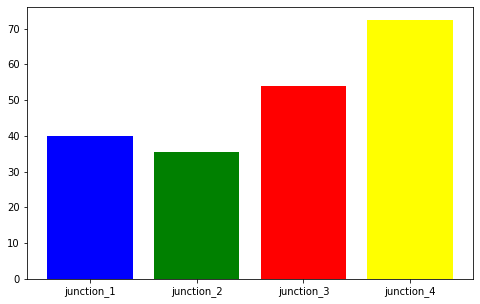

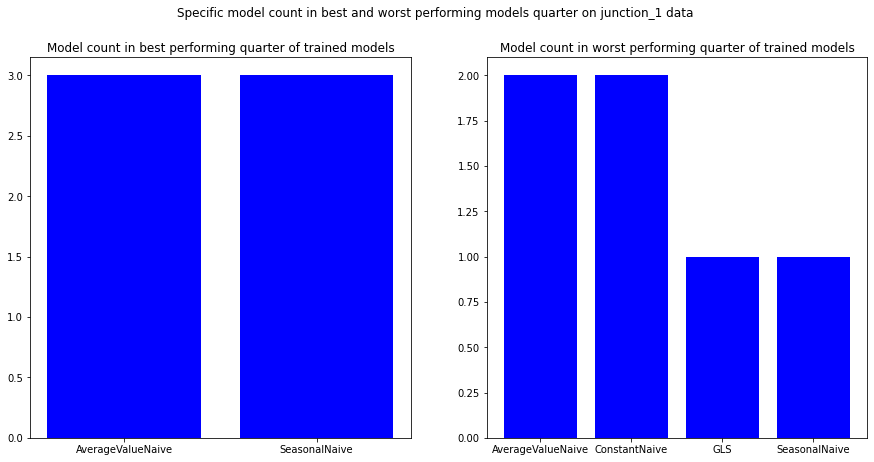

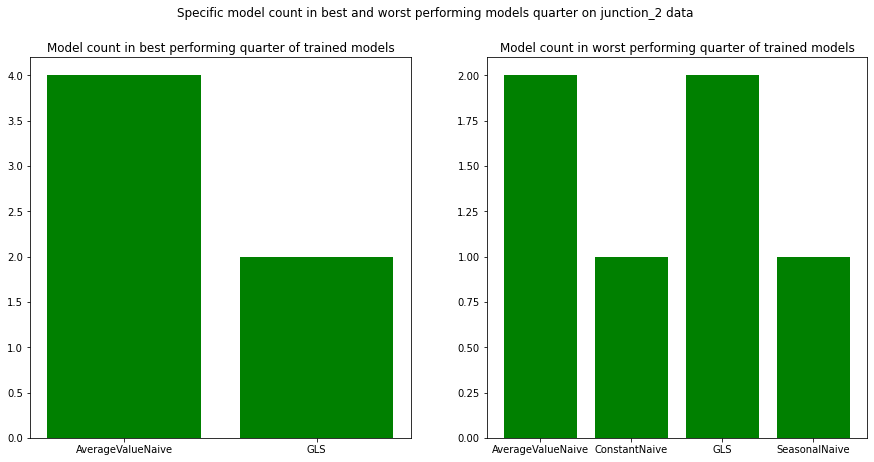

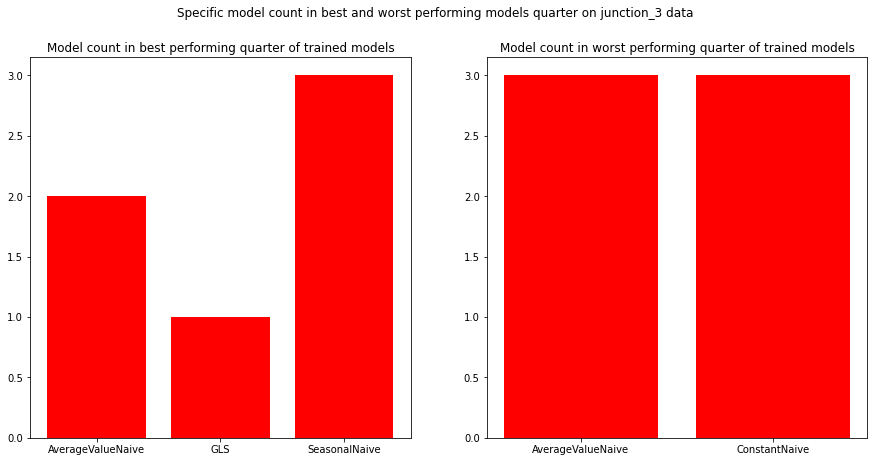

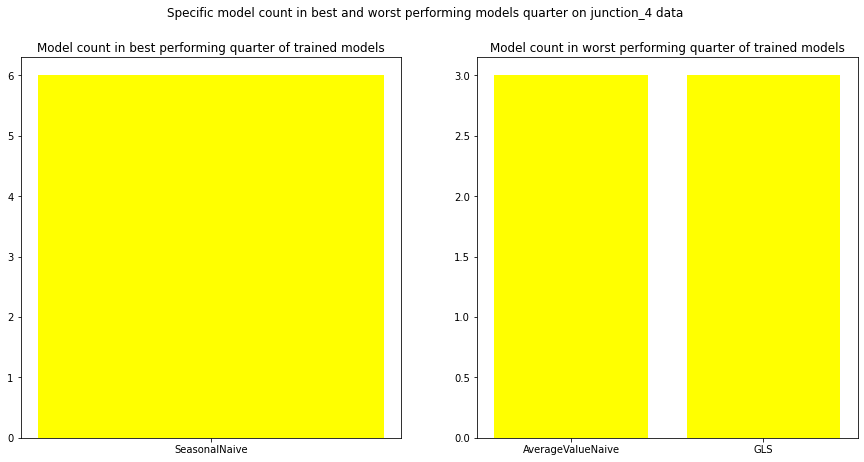

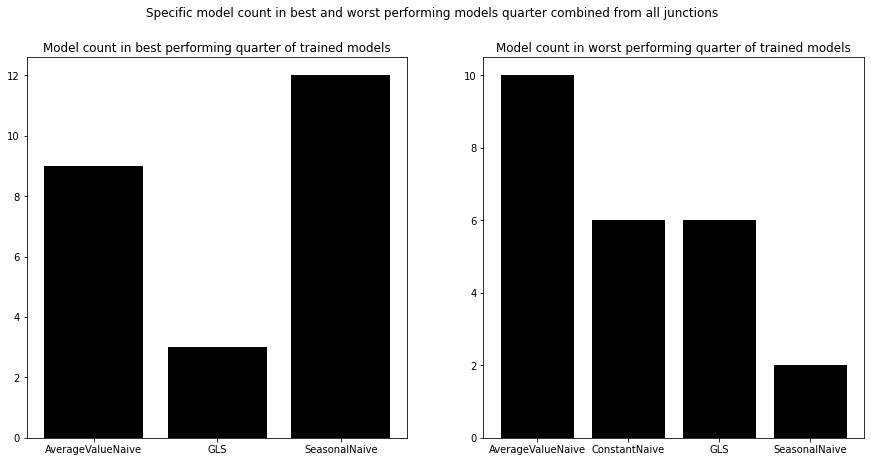

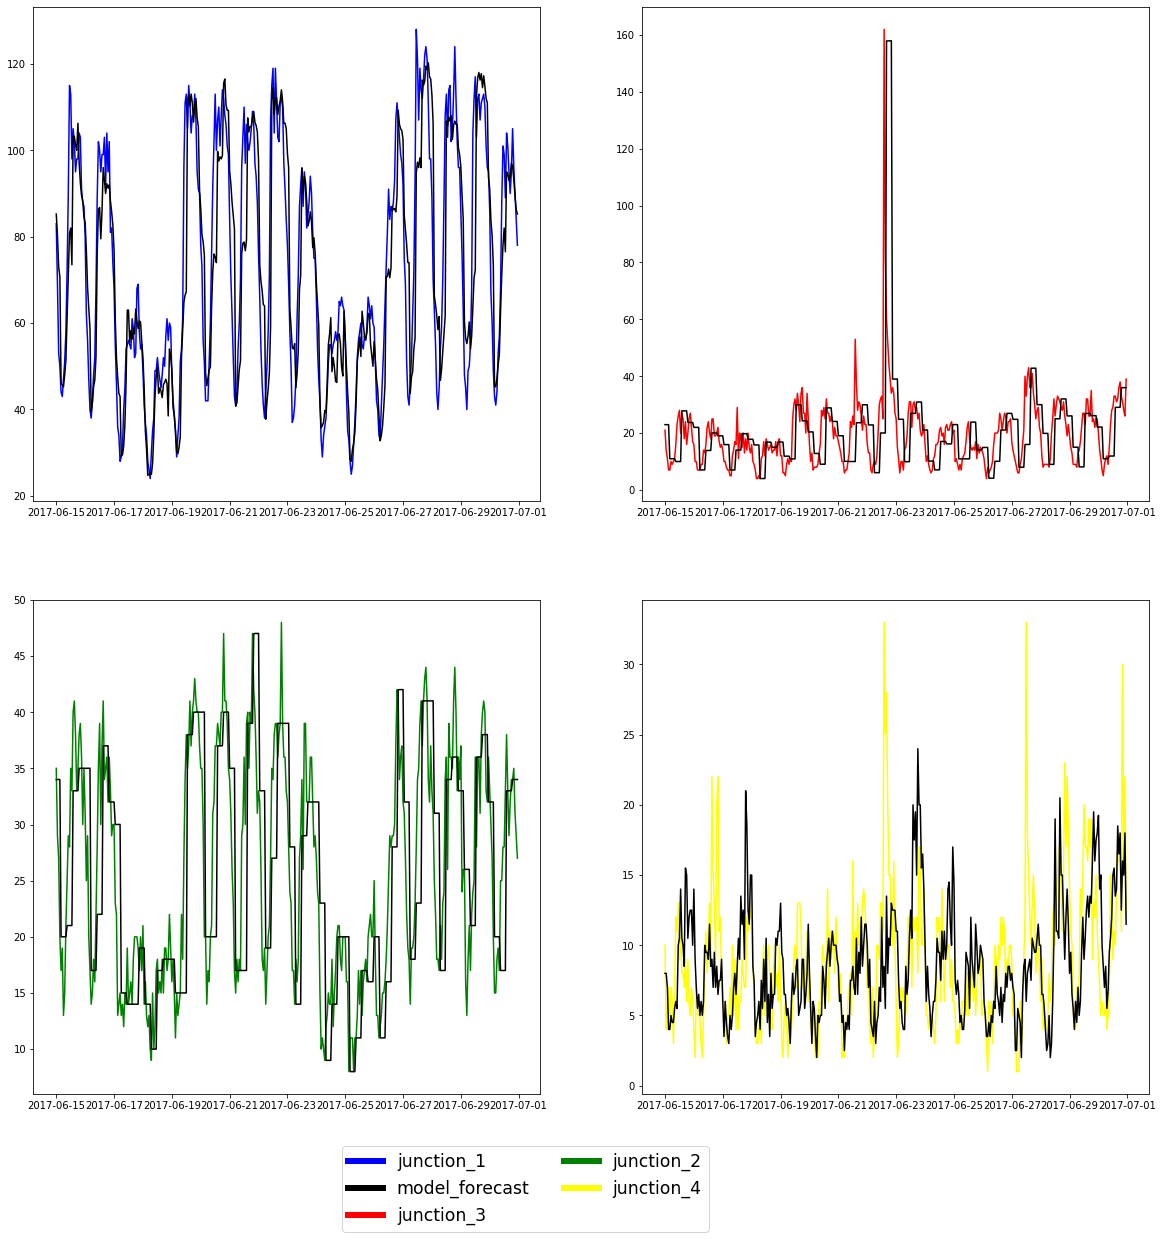

In [96]:
create_report_materials_out_of_trained_models()

In [ ]:
#plot_horizontal????? autots stat zu ausgewählten modellen?????